In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import auc
from sklearn.utils.extmath import stable_cumsum
from sklearn.utils.validation import check_consistent_length
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import warnings
import numpy as np
from sklearn.utils.extmath import stable_cumsum
from sklearn.utils.validation import check_consistent_length
from sklearn.metrics import auc

from torch.autograd import Variable

import numpy as np
import pandas as pd

from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt

from numpy import asarray
from numpy import savez_compressed

def uplift_curve(y_true, uplift, treatment):
   

    check_consistent_length(y_true, uplift, treatment)
    
    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    desc_score_indices = np.argsort(uplift, kind="mergesort")[::-1]
    y_true, uplift, treatment = y_true[desc_score_indices], uplift[desc_score_indices], treatment[desc_score_indices]

    y_true_ctrl, y_true_trmnt = y_true.copy(), y_true.copy()

    y_true_ctrl[treatment == 1] = 0
    y_true_trmnt[treatment == 0] = 0

    distinct_value_indices = np.where(np.diff(uplift))[0]
    threshold_indices = np.r_[distinct_value_indices, uplift.size - 1]

    num_trmnt = stable_cumsum(treatment)[threshold_indices]
    y_trmnt = stable_cumsum(y_true_trmnt)[threshold_indices]

    num_all = threshold_indices + 1

    num_ctrl = num_all - num_trmnt
    y_ctrl = stable_cumsum(y_true_ctrl)[threshold_indices]

    curve_values = (np.divide(y_trmnt, num_trmnt, out=np.zeros_like(y_trmnt), where=num_trmnt != 0) -
                    np.divide(y_ctrl, num_ctrl, out=np.zeros_like(y_ctrl), where=num_ctrl != 0)) * num_all

    if num_all.size == 0 or curve_values[0] != 0 or num_all[0] != 0:
        # Add an extra threshold position if necessary
        # to make sure that the curve starts at (0, 0)
        num_all = np.r_[0, num_all]
        curve_values = np.r_[0, curve_values]

    return num_all, curve_values


def perfect_uplift_curve(y_true, treatment):
  

    check_consistent_length(y_true, treatment)
    
    y_true, treatment = np.array(y_true), np.array(treatment)

    cr_num = np.sum((y_true == 1) & (treatment == 0))  # Control Responders
    tn_num = np.sum((y_true == 0) & (treatment == 1))  # Treated Non-Responders

    # express an ideal uplift curve through y_true and treatment
    summand = y_true if cr_num > tn_num else treatment
    perfect_uplift = 2 * (y_true == treatment) + summand

    return uplift_curve(y_true, perfect_uplift, treatment)


def uplift_auc_score(y_true, uplift, treatment):
   

    check_consistent_length(y_true, uplift, treatment)
    
    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    x_actual, y_actual = uplift_curve(y_true, uplift, treatment)
    x_perfect, y_perfect = perfect_uplift_curve(y_true, treatment)
    x_baseline, y_baseline = np.array([0, x_perfect[-1]]), np.array([0, y_perfect[-1]])

    auc_score_baseline = auc(x_baseline, y_baseline)
    auc_score_perfect = auc(x_perfect, y_perfect) - auc_score_baseline
    auc_score_actual = auc(x_actual, y_actual) - auc_score_baseline

    return auc_score_actual / auc_score_perfect

In [26]:
!git clone https://github.com/pianonyy/UPLIFT_modeling.git

Cloning into 'UPLIFT_modeling'...


In [27]:
!pip install -e UPLIFT_modeling/

Obtaining file:///D:/Uplift_May_experiments/UPLIFT_modeling

You should consider upgrading via the 'C:\Python38\python.exe -m pip install --upgrade pip' command.



  Attempting uninstall: uplift
    Found existing installation: uplift 0.1
    Uninstalling uplift-0.1:
      Successfully uninstalled uplift-0.1
  Running setup.py develop for uplift


In [9]:
df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')

indices_train, indices_test = train_test_split(
         df_train_feats.index,
         test_size=0.3,
         random_state = 13
)


treatment_train = df_train_feats.loc[indices_train,'treatment_flg']
y_train = df_train_feats.loc[indices_train,'target']


treatment_test = df_train_feats.loc[indices_test,'treatment_flg']
y_test = df_train_feats.loc[indices_test,'target']

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

df_train_feats = df_train_feats.replace([np.inf, -np.inf], np.nan).fillna(0)

x_train = df_train_feats.loc[indices_train]
x_test = df_train_feats.loc[indices_test]


print("train shape:", x_train.shape)
print("test shape:", x_test.shape)

train shape: (140024, 6)
test shape: (60011, 6)


In [14]:
all = pd.DataFrame({
    "treatment":treatment_train,
    "target": y_train
})
all['Z_trans'] = 0

all.loc[(all['target'] == 1) & (all['treatment'] == 1),'Z_trans'] = 2
all.loc[(all['target'] == 1) & (all['treatment'] == 0),'Z_trans'] =  -2
all.loc[all['Z_trans'].isnull(), 'Z_trans'] = 0

Z_trans_train = all['Z_trans']

all = pd.DataFrame({
    "treatment":treatment_test,
    "target": y_test
})
all['Z_trans'] = 0

all.loc[(all['target'] == 1) & (all['treatment'] == 1),'Z_trans'] = 2
all.loc[(all['target'] == 1) & (all['treatment'] == 0),'Z_trans'] =  -2
all.loc[all['Z_trans'].isnull(), 'Z_trans'] = 0

Z_trans_test = all['Z_trans']

In [15]:
from sklearn.preprocessing import StandardScaler 
import numpy as np


scaler = StandardScaler(with_std = True, with_mean = True)

X_train_0 = x_train.copy()


X_train_1 = x_train.copy()


X_train_1 = X_train_1.astype('float32')
X_train_1 = X_train_1.replace([np.inf, -np.inf], np.nan).fillna(0)
X_train_1 = scaler.fit_transform(X_train_1)

X_train_0 = X_train_0.astype('float32')
X_train_0 = X_train_0.replace([np.inf, -np.inf], np.nan).fillna(0)
X_train_0 = scaler.fit_transform(X_train_0)


X_test_0 = x_test.copy()


X_test_1 = x_test.copy()


X_test_1 = X_test_1.astype('float32')
X_test_1 = X_test_1.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test_1 = scaler.fit_transform(X_test_1)

X_test_0 = X_test_0.astype('float32')
X_test_0 = X_test_0.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test_0 = scaler.fit_transform(X_test_0)

X_test_0 = np.c_[ X_test_0, np.zeros(X_test_0.shape[0]) ]
X_test_1 = np.c_[ X_test_1, np.ones(X_test_1.shape[0]) ] 

X_train_0 = np.c_[ X_train_0, np.zeros(X_train_0.shape[0]) ]
X_train_1 = np.c_[ X_train_1, np.ones(X_train_1.shape[0]) ]

In [16]:
print(X_train_0.shape)
print(X_train_1.shape)
print(Z_trans_train.shape)
print(treatment_train.shape)
print(y_test.shape)

(140024, 7)
(140024, 7)
(140024,)
(140024,)
(60011,)


# Подбор параметров одна модель

In [ ]:
from pprint import pprint

max_depth = [int(x) for x in np.linspace(2, 9, num = 4)]

n_estimators = [int(x) for x in np.linspace(10, 15000, num = 8)]
subsample = [float(x) for x in np.linspace(0.4,1,num=3)]
colsample_bytree = [float(x) for x in np.linspace(0.4,1,num=3)]

param_grid = {
              'max_depth':max_depth,
              'subsample':subsample,
              'colsample_bytree':colsample_bytree
             }

pprint(param_grid)

from sklearn.model_selection import ParameterGrid

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)

{'colsample_bytree': [0.4, 0.7, 1.0],
 'max_depth': [2, 4, 6, 9],
 'subsample': [0.4, 0.7, 1.0]}


In [ ]:
print(df_train_feats.info())

<class 'pandas.core.frame.DataFrame'>
Index: 200035 entries, 000012768d to fffe0abb97
Data columns (total 6 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   first_redeem_date                   200035 non-null  int64  
 1   express_spent_mean                  200035 non-null  float64
 2   express_points_spent_sum            200035 non-null  float64
 3   regular_points_received_sum_last_m  200035 non-null  float64
 4   avg_spent_perday                    200035 non-null  float64
 5   after_redeem_sum_perday             200035 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 15.7+ MB
None


# Одна модель

In [ ]:
from UPLIFT_modeling.uplift.models import OneModel
from UPLIFT_modeling.uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

accuracy_auqc = {}
accuracy = {}
num_folds = 2
# eval_set = [(np.column_stack((eval_x,eval_treat)), eval_y)]
best_param = {}
best_param_auqc = {}
indices_all_folds = np.array_split(indices_train, num_folds)
#cross validation
print(indices_train.shape)

best_auqc = 0.0
lr = 0.01
RANDOM_STATE = 12

df_train_feats = pd.read_csv("/content/drive/MyDrive/retail_hero_final_model_train_data.csv", index_col = 'client_id')

treat_y = pd.DataFrame({
    'treatment_flg':df_train_feats['treatment_flg'],
    'target':df_train_feats['target']
}, index = df_train_feats.index)

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

for j, params in enumerate(grid_list):
    print("iteration", j," with params", params)
    
    clf_ = LGBMClassifier(
            boosting_type='gbdt',
            num_leaves=2**params['max_depth'] -1,
            max_depth=params['max_depth'],
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=params['subsample'],
            colsample_bytree = params['colsample_bytree']
    )



    
    auqc_res= []
    
    for i in range(num_folds):

        x_val = df_train_feats.loc[indices_all_folds[i]].values
        y_val = treat_y.loc[indices_all_folds[i],'target'].values
        treatment_val = treat_y.loc[indices_all_folds[i],'treatment_flg'].values




        united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
        united = united.reshape(indices_train.shape[0] // 2)

        x_train = df_train_feats.loc[united].values
        y_train = treat_y.loc[united, 'target'].values
        treatment_train = treat_y.loc[united, 'treatment_flg'].values
        
        best = 0
        rounds = 0
        step = 30
        print("start early stopping")
        for n_est in range(2,3000,step):
            
            seting = {'n_estimators':n_est}
            print("[",n_est,"]")
            clf_.set_params(**seting)
           
            solo = OneModel(clf_)
            
            if (rounds == 3):
                print("earlystopping finish, best iteration", n_est - (step * rounds))
                break
                
            solo.fit(x_train,y_train,treatment_train)
            pred = solo.predict(x_val)

            auqc = qini_auc_score(y_val, pred, treatment_val)
            

            print(params, 'auqc',auqc)
            
            if (auqc > best):
                best = auqc
                rounds = 0
            else:
                rounds += 1
                
        auqc_res.append(best)   
        
    mid = np.mean(auqc_res)
    if mid > best_auqc:
        accuracy_auqc[j] = mid
        best_param_auqc[j] = [params]
        print("iteration {}, auqc {}, params {}".format(j,mid,[params]))
        best_auqc = mid
        
    
    
print("best accuracies in folds:")
print(accuracy_auqc)
print(best_param_auqc)

(140024,)
iteration 0  with params {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 0.0
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 10661498.137244813
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 10633038.629469901
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 10646538.074916176
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 10689051.096857093
[ 152 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 10796423.518345915
[ 182 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 10785891.904307507
[ 212 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 10972050.883788154
[ 242 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 11200691.911823086
[ 272 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 116

In [ ]:
from UPLIFT_modeling.uplift.models import OneModel
from UPLIFT_modeling.uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

lr=0.01
RANDOM_STATE = 12
max_depth = 4
colsample_bytree = 0.7
subsample=0.4
n_estimators = 482

clf_ = LGBMClassifier(
        boosting_type='gbdt',
        num_leaves=2**max_depth -1,
        max_depth=max_depth,
        learning_rate=lr,
        random_state=RANDOM_STATE,
        objective='binary',
        reg_alpha=0.0,
        reg_lambda=0.0,
        silent=True,
        n_estimators=n_estimators,
        subsample=subsample,
        colsample_bytree = colsample_bytree
)
print(clf_)
tranf = OneModel(clf_)
tranf.fit(x_train, y_train, treatment_train)


from UPLIFT_modeling.uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []


df_train_feats = pd.read_csv("/content/drive/MyDrive/out.csv", index_col = 'client_id')

treat_y = pd.DataFrame({
    'treatment_flg':df_train_feats['treatment_flg'],
    'target':df_train_feats['target']
}, index = df_train_feats.index)


df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target'], 
            axis=1
)
print(treat_y)
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   
    treatment_valid = treat_y.loc[indices_valid_new, 'treatment_flg'].values
    target_valid =  treat_y.loc[indices_valid_new, 'target'].values
    X_valid = df_train_feats.loc[indices_valid_new, :]
    
    


    valid_pred = tranf.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
               importance_type='split', learning_rate=0.01, max_depth=4,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=482, n_jobs=-1, num_leaves=15, objective='binary',
               random_state=12, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.4, subsample_for_bin=200000, subsample_freq=0)
            treatment_flg  target
client_id                        
000012768d              0       1
000036f903              1       1
00010925a5              1       1
0001f552b0              1       1
00020e7b18              1       1
...                   ...     ...
fffcb91f10              1       0
fffd5cd0c6              1       1
fffd63dfe3              1       1
fffd8c9d7d              1       0
fffe0abb97              0       0

[200035 rows x 2 columns]
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0

In [ ]:
from UPLIFT_modeling.uplift.models import OneModel
from UPLIFT_modeling.uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

lr=0.01
RANDOM_STATE = 12
max_depth = 4
colsample_bytree = 0.7
subsample=0.4
n_estimators = 482

clf_ = LGBMClassifier(
        boosting_type='gbdt',
        num_leaves=2**max_depth -1,
        max_depth=max_depth,
        learning_rate=lr,
        random_state=RANDOM_STATE,
        objective='binary',
        reg_alpha=0.0,
        reg_lambda=0.0,
        silent=True,
        n_estimators=n_estimators,
        subsample=subsample,
        colsample_bytree = colsample_bytree
)
print(clf_)
tranf = OneModel(clf_)
tranf.fit(x_train, y_train, treatment_train)


from UPLIFT_modeling.uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []


df_train_feats = pd.read_csv("/content/drive/MyDrive/retail_hero_final_model_train_data.csv", index_col = 'client_id')

treat_y = pd.DataFrame({
    'treatment_flg':df_train_feats['treatment_flg'],
    'target':df_train_feats['target']
}, index = df_train_feats.index)

print(treat_y)
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   
    treatment_valid = treat_y.loc[indices_valid_new, 'treatment_flg'].values
    target_valid =  treat_y.loc[indices_valid_new, 'target'].values
    X_valid = x_test.loc[indices_valid_new, :]
    
    


    valid_pred = tranf.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
               importance_type='split', learning_rate=0.01, max_depth=4,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=482, n_jobs=-1, num_leaves=15, objective='binary',
               random_state=12, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.4, subsample_for_bin=200000, subsample_freq=0)
            treatment_flg  target
client_id                        
000012768d              0       1
000036f903              1       1
00010925a5              1       1
0001f552b0              1       1
00020e7b18              1       1
...                   ...     ...
fffcb91f10              1       0
fffd5cd0c6              1       1
fffd63dfe3              1       1
fffd8c9d7d              1       0
fffe0abb97              0       0

[200035 rows x 2 columns]
Kendal uplift rank correlation =  0.6 with p_value =  0.01666611552028

In [ ]:
from UPLIFT_modeling.uplift.models import OneModel
from UPLIFT_modeling.uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

lr=0.01
RANDOM_STATE = 12
max_depth = 4
colsample_bytree = 0.7
subsample=0.4
n_estimators = 482

clf_ = LGBMClassifier(
        boosting_type='gbdt',
        num_leaves=2**max_depth -1,
        max_depth=max_depth,
        learning_rate=lr,
        random_state=RANDOM_STATE,
        objective='binary',
        reg_alpha=0.0,
        reg_lambda=0.0,
        silent=True,
        n_estimators=n_estimators,
        subsample=subsample,
        colsample_bytree = colsample_bytree
)
print(clf_)
tranf = OneModel(clf_)
tranf.fit(x_train, y_train, treatment_train)


from UPLIFT_modeling.uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []


df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')

treat_y = pd.DataFrame({
    'treatment_flg':df_train_feats['treatment_flg'],
    'target':df_train_feats['target']
}, index = df_train_feats.index)

print(treat_y)
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   
    treatment_valid = treat_y.loc[indices_valid_new, 'treatment_flg'].values
    target_valid =  treat_y.loc[indices_valid_new, 'target'].values
    X_valid = x_test.loc[indices_valid_new, :]
    
    


    valid_pred = tranf.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
               importance_type='split', learning_rate=0.01, max_depth=4,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=482, n_jobs=-1, num_leaves=15, objective='binary',
               random_state=12, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.4, subsample_for_bin=200000, subsample_freq=0)
            treatment_flg  target
client_id                        
000012768d              0       1
000036f903              1       1
00010925a5              1       1
0001f552b0              1       1
00020e7b18              1       1
...                   ...     ...
fffcb91f10              1       0
fffd5cd0c6              1       1
fffd63dfe3              1       1
fffd8c9d7d              1       0
fffe0abb97              0       0

[200035 rows x 2 columns]
Kendal uplift rank correlation =  0.6 with p_value =  0.01666611552028

In [7]:
from uplift.models import OneModel
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

from scipy import stats
lr=0.01
RANDOM_STATE = 12
max_depth = 4
colsample_bytree = 0.7
subsample=0.4
n_estimators = 482

clf_ = LGBMClassifier(
        boosting_type='gbdt',
        num_leaves=2**max_depth -1,
        max_depth=max_depth,
        learning_rate=lr,
        random_state=RANDOM_STATE,
        objective='binary',
        reg_alpha=0.0,
        reg_lambda=0.0,
        silent=True,
        n_estimators=n_estimators,
        subsample=subsample,
        colsample_bytree = colsample_bytree
)
print(clf_)
tranf = OneModel(clf_)
tranf.fit(x_train, y_train, treatment_train)



all_res_uplift = []



df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')

treat_y = pd.DataFrame({
    'treatment_flg':df_train_feats['treatment_flg'],
    'target':df_train_feats['target']
}, index = df_train_feats.index)


for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   
    treatment_valid = treat_y.loc[indices_valid_new, 'treatment_flg'].values
    target_valid =  treat_y.loc[indices_valid_new, 'target'].values
    X_valid = x_test.loc[indices_valid_new, :]
    
    


    valid_pred = tranf.predict(X_valid)
   
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid,rate = 0.05)
    
    
    all_res_uplift.append(valid_scores)
    
    
print('Число замеров', j)

print('uplift5%: mean: ', np.mean(all_res_uplift),"| sem: ",stats.sem(all_res_uplift))


LGBMClassifier(colsample_bytree=0.7, learning_rate=0.01, max_depth=4,
               n_estimators=482, num_leaves=15, objective='binary',
               random_state=12, subsample=0.4)
Число замеров 100
uplift5%: mean:  0.1892535231138636 | sem:  0.002683049264956233


# Трансформация классов

In [ ]:
from UPLIFT_modeling.uplift.models import ClassTransformation
from UPLIFT_modeling.uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

accuracy_auqc = {}
accuracy_tranf = {}
num_folds = 2
# eval_set = [(np.column_stack((eval_x,eval_treat)), eval_y)]
best_param = {}
best_param_auqc_tranf = {}
indices_all_folds = np.array_split(indices_train, num_folds)
#cross validation
print(indices_train.shape)

best_auqc = 0.0
lr = 0.01
RANDOM_STATE = 12

df_train_feats = pd.read_csv("/content/drive/MyDrive/retail_hero_final_model_train_data.csv", index_col = 'client_id')

treat_y = pd.DataFrame({
    'treatment_flg':df_train_feats['treatment_flg'],
    'target':df_train_feats['target']
}, index = df_train_feats.index)

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

for j, params in enumerate(grid_list):
    print("iteration", j," with params", params)
    
    clf_ = LGBMClassifier(
            boosting_type='gbdt',
            num_leaves=2**params['max_depth'] -1,
            max_depth=params['max_depth'],
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=params['subsample'],
            colsample_bytree = params['colsample_bytree']
    )



    
    auqc_res= []
    
    for i in range(num_folds):

        x_val = df_train_feats.loc[indices_all_folds[i]].values
        y_val = treat_y.loc[indices_all_folds[i],'target'].values
        treatment_val = treat_y.loc[indices_all_folds[i],'treatment_flg'].values




        united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
        united = united.reshape(indices_train.shape[0] // 2)

        x_train = df_train_feats.loc[united].values
        y_train = treat_y.loc[united, 'target'].values
        treatment_train = treat_y.loc[united, 'treatment_flg'].values
        
        best = 0
        rounds = 0
        step = 30
        print("start early stopping")
        for n_est in range(2,3000,step):
            
            seting = {'n_estimators':n_est}
            print("[",n_est,"]")
            clf_.set_params(**seting)
           
            tranf = ClassTransformation(clf_)
            
            if (rounds == 3):
                print("earlystopping finish, best iteration", n_est - (step * rounds))
                break
                
            tranf.fit(x_train,y_train,treatment_train)
            pred = tranf.predict(x_val)

            auqc = qini_auc_score(y_val, pred, treatment_val)
            

            print(params, 'auqc',auqc)
            
            if (auqc > best):
                best = auqc
                rounds = 0
            else:
                rounds += 1
                
        auqc_res.append(best)   
        
    mid = np.mean(auqc_res)
    if mid > best_auqc:
        accuracy_tranf[j] = mid
        best_param_auqc_tranf[j] = [params]
        print("iteration {}, auqc {}, params {}".format(j,mid,[params]))
        best_auqc = mid
        
    
    
print("best accuracies in folds:")
print(accuracy_tranf)
print(best_param_auqc_tranf)

(140024,)
iteration 0  with params {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 7781281.810294911
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 17705752.25445514
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 18066838.46399504
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 19990808.294718064
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 20453315.13458696
[ 152 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 20893686.20155374
[ 182 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 21371084.098249726
[ 212 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 23052146.460465103
[ 242 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 23498879.81208107
[ 272 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}

In [ ]:
from UPLIFT_modeling.uplift.models import ClassTransformation
from UPLIFT_modeling.uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

max_depth = 2
colsample_bytree = 1.0
subsample=0.4
n_estimators = 662

clf_ = LGBMClassifier(
        boosting_type='gbdt',
        num_leaves=2**max_depth -1,
        max_depth=max_depth,
        learning_rate=lr,
        random_state=RANDOM_STATE,
        objective='binary',
        reg_alpha=0.0,
        reg_lambda=0.0,
        silent=True,
        n_estimators=n_estimators,
        subsample=subsample,
        colsample_bytree = colsample_bytree
)
print(clf_)
tranf = ClassTransformation(clf_)
tranf.fit(x_train, y_train, treatment_train)


from UPLIFT_modeling.uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []



treat_y = pd.DataFrame({
    'treatment_flg':df_train_feats['treatment_flg'],
    'target':df_train_feats['target']
}, index = df_train_feats.index)

print(treat_y)
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   
    treatment_valid = treat_y.loc[indices_valid_new, 'treatment_flg'].values
    target_valid =  treat_y.loc[indices_valid_new, 'target'].values
    X_valid = x_test.loc[indices_valid_new, :]
    
    


    valid_pred = tranf.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=2,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=662, n_jobs=-1, num_leaves=3, objective='binary',
               random_state=100, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.4, subsample_for_bin=200000, subsample_freq=0)


/content/UPLIFT_modeling/uplift/models/models.py:79: UserWarning:

sample size is not balanced.



            treatment_flg  target
client_id                        
000012768d              0       1
000036f903              1       1
00010925a5              1       1
0001f552b0              1       1
00020e7b18              1       1
...                   ...     ...
fffcb91f10              1       0
fffd5cd0c6              1       1
fffd63dfe3              1       1
fffd8c9d7d              1       0
fffe0abb97              0       0

[200035 rows x 2 columns]
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.291248346560

In [8]:
from uplift.models import ClassTransformation
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

max_depth = 2
colsample_bytree = 1.0
subsample=0.4
n_estimators = 662

clf_ = LGBMClassifier(
        boosting_type='gbdt',
        num_leaves=2**max_depth -1,
        max_depth=max_depth,
        learning_rate=lr,
        random_state=RANDOM_STATE,
        objective='binary',
        reg_alpha=0.0,
        reg_lambda=0.0,
        silent=True,
        n_estimators=n_estimators,
        subsample=subsample,
        colsample_bytree = colsample_bytree
)
print(clf_)
tranf = ClassTransformation(clf_)
tranf.fit(x_train, y_train, treatment_train)




all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []



treat_y = pd.DataFrame({
    'treatment_flg':df_train_feats['treatment_flg'],
    'target':df_train_feats['target']
}, index = df_train_feats.index)


for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   
    treatment_valid = treat_y.loc[indices_valid_new, 'treatment_flg'].values
    target_valid =  treat_y.loc[indices_valid_new, 'target'].values
    X_valid = x_test.loc[indices_valid_new, :]
    
    


    valid_pred = tranf.predict(X_valid)
    
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid, rate = 0.05)
    
    
    all_res_uplift.append(valid_scores)

    
print('Число замеров', j)

print('uplift5%: mean: ', np.mean(all_res_uplift),"| sem: ", stats.sem(all_res_uplift))


2021-05-06 13:59:27,802 [16752] WARNING  py.warnings:109: [JupyterRequire] d:\work\ml_in_trading\uplift_modeling_lib\uplift\models\models.py:78: UserWarning:

sample size is not balanced.




LGBMClassifier(learning_rate=0.01, max_depth=2, n_estimators=662, num_leaves=3,
               objective='binary', random_state=100, subsample=0.4)
Число замеров 100
uplift5%: mean:  0.3208597746875116 | sem:  0.0024734001297904576


In [24]:
import warnings
import numpy as np
from sklearn.utils.extmath import stable_cumsum
from sklearn.utils.validation import check_consistent_length
from sklearn.metrics import auc
import pandas as pd

import plotly.express as px

import scipy.stats as stats

from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)


#percentile approach to qini measurement

def declare_tc(df):
   
    
    df['target_class'] = 0 
    
    df.loc[(df.treatment == 0) & (df.target != 0),'target_class'] = 1 
  
    df.loc[(df.treatment != 0) & (df.target == 0),'target_class'] = 2 
    
    df.loc[(df.treatment != 0) & (df.target != 0),'target_class'] = 3 
    return df


def qini_rank(Y_test_visit, pred, treatment_test):
    
    uplift = pd.DataFrame({'target':Y_test_visit,'treatment':treatment_test, 'uplift_score':pred})
    
    uplift = declare_tc(uplift)
    
    ranked = pd.DataFrame({'n':[], 'target_class':[]})
    
    ranked['target_class'] = uplift['target_class']
    ranked['uplift_score'] = uplift['uplift_score']
    
    
  
    ranked['n'] = ranked.uplift_score.rank(pct=True, ascending=False)
   
   
    ranked = ranked.sort_values(by='n').reset_index(drop=True)

    
    print(ranked)
    return ranked


def qini_eval(ranked):
    
    
    uplift_model, random_model = ranked.copy(), ranked.copy()
    # Using Treatment and Control Group to calculate the uplift 
    C, T = sum(ranked['target_class'] <= 1), sum(ranked['target_class'] >= 2)
    ranked['cr'] = 0
    ranked['tr'] = 0
    ranked.loc[ranked.target_class == 1,'cr'] = 1
    ranked.loc[ranked.target_class == 3,'tr'] = 1
    ranked['cr/c'] = ranked.cr.cumsum() / C
    ranked['tr/t'] = ranked.tr.cumsum() / T
    # Calculate and put the uplift and random value into dataframe
    uplift_model['uplift'] = round(ranked['tr/t'] - ranked['cr/c'],5)
    random_model['uplift'] = round(ranked['n'] * uplift_model['uplift'].iloc[-1],5)
    
    
    # Add start point
    q0 = pd.DataFrame({'n':0, 'uplift':0, 'target_class': None}, index =[0])
    uplift_model = pd.concat([q0, uplift_model],sort=False).reset_index(drop = True)
    random_model = pd.concat([q0, random_model],sort=False).reset_index(drop = True)  
    # Add model name & concat
    uplift_model['model'] = 'Uplift model'
    random_model['model'] = 'Random model'
    merged = pd.concat([uplift_model, random_model]).sort_values(by='n').reset_index(drop = True)
    merged = merged.groupby(['n','model'],as_index=False).mean()
    print(merged)
    return merged


def qini_plot(merged):
    fig = px.line(merged, x="n", y="uplift", color='model', labels={
                     "n": "ratio",
                     "uplift": "uplift"
                    }
                )
    
    fig.show()
    

    


def qini_percentile(Y_test_visit,pred,treatment_test):
  
    ranked = qini_rank(Y_test_visit,pred,treatment_test)
    merged = qini_eval(ranked)
    qini_plot(merged)
   



#absolute numbers qini curve
def qini_curve(y_true, uplift, treatment): 

    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    desc_score_indices = np.argsort(uplift, kind="mergesort")[::-1]

    y_true = y_true[desc_score_indices]
    treatment = treatment[desc_score_indices]
    uplift = uplift[desc_score_indices]

    y_true_ctrl, y_true_trmnt = y_true.copy(), y_true.copy()

    y_true_ctrl[treatment == 1] = 0
    y_true_trmnt[treatment == 0] = 0

    distinct_value_indices = np.where(np.diff(uplift))[0]
    threshold_indices = np.r_[distinct_value_indices, uplift.size - 1]

    #print(threshold_indices.size)

    num_trmnt = stable_cumsum(treatment)[threshold_indices]
    y_trmnt = stable_cumsum(y_true_trmnt)[threshold_indices]

    num_all = threshold_indices + 1

    num_ctrl = num_all - num_trmnt
    y_ctrl = stable_cumsum(y_true_ctrl)[threshold_indices]

    curve_values = y_trmnt - y_ctrl * np.divide(num_trmnt, num_ctrl, out=np.zeros_like(num_trmnt), where=num_ctrl != 0)
    if num_all.size == 0 or curve_values[0] != 0 or num_all[0] != 0:
       
        num_all = np.r_[0, num_all]
        curve_values = np.r_[0, curve_values]

    return num_all, curve_values

def perfect_qini_curve(y_true, treatment):
  
    check_consistent_length(y_true, treatment)
    n_samples = len(y_true)

    y_true, treatment = np.array(y_true), np.array(treatment)

    
    
    x_perfect, y_perfect = qini_curve(
            y_true, y_true * treatment - y_true * (1 - treatment), treatment
    )
    

    return x_perfect, y_perfect



def qini_auc_score(y_true, uplift, treatment, negative_effect=True):
   
    check_consistent_length(y_true, uplift, treatment)

    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    treatment_count = np.count_nonzero(treatment == 1)


    x_model, y_model = qini_curve(y_true, uplift, treatment)
    x_perfect, y_perfect = perfect_qini_curve(y_true, treatment)
    x_baseline, y_baseline = np.array([0, x_perfect[-1]]), np.array([0, y_perfect[-1]])
    
    # print(np.size(treatment))
    #x_baseline, y_baseline = np.array([np.arange(0, np.size(treatment))]), np.array([0, y_perfect[-1]])
    

    auc_score_baseline = auc(x_baseline, y_baseline)
    auc_score_perfect = auc(x_perfect, y_perfect) - auc_score_baseline
    auc_score_model = auc(x_model, y_model) - auc_score_baseline

    return auc_score_model

2021-05-07 16:49:50,348 [19272] WARNING  py.warnings:109: [JupyterRequire] d:\work\ml_in_trading\uplift_modeling_lib\uplift\models\models.py:78: UserWarning:

sample size is not balanced.




LGBMClassifier(learning_rate=0.01, max_depth=2, n_estimators=662, num_leaves=3,
               objective='binary', random_state=100, subsample=0.4)
Число замеров 100
AUQC: mean:  15474.941855034669 | std:  391640.93387850147
uplift5%: mean:  0.3208597746875116 | sem:  0.0024734001297904576


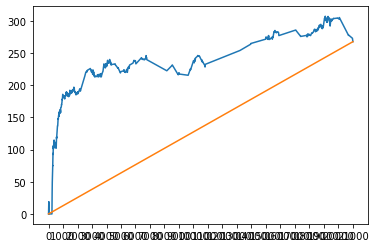

In [28]:
from uplift.models import ClassTransformation
from UPLIFT_modeling.uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier
from scipy import stats

max_depth = 2
colsample_bytree = 1.0
subsample=0.4
n_estimators = 662
lr = 0.01
RANDOM_STATE = 100

clf_ = LGBMClassifier(
        boosting_type='gbdt',
        num_leaves=2**max_depth -1,
        max_depth=max_depth,
        learning_rate=lr,
        random_state=RANDOM_STATE,
        objective='binary',
        reg_alpha=0.0,
        reg_lambda=0.0,
        silent=True,
        n_estimators=n_estimators,
        subsample=subsample,
        colsample_bytree = colsample_bytree
)
print(clf_)
tranf = ClassTransformation(clf_)
tranf.fit(x_train, y_train, treatment_train)




all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []


df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')
treat_y = pd.DataFrame({
    'treatment_flg':df_train_feats['treatment_flg'],
    'target':df_train_feats['target']
}, index = df_train_feats.index)


for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   
    treatment_valid = treat_y.loc[indices_valid_new, 'treatment_flg'].values
    target_valid =  treat_y.loc[indices_valid_new, 'target'].values
    X_valid = x_test.loc[indices_valid_new, :]
    
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
    


    valid_pred = tranf.predict(X_valid)
    
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid, rate = 0.05)
    
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)

from UPLIFT_modeling.uplift.metrics import  qini_curve




x1, y1 = qini_curve(target_valid, valid_pred, treatment_valid)

np.savetxt('x_transf_classes.txt', x1)
np.savetxt('y_transf_classes.txt', y1)

plt.plot(x1,y1)
plt.xticks(np.arange (0, x1[len(x1)-1], step=1000))
plt.plot([ x1[0], x1[len(x1)-1] ], [ y1[0], y1[len(y1) - 1  ]] )    

print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift5%: mean: ', np.mean(all_res_uplift),"| sem: ", stats.sem(all_res_uplift))


# Две зависимые модели T C

In [ ]:
from UPLIFT_modeling.uplift.models import TwoModels
from UPLIFT_modeling.uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

accuracy_auqc = {}
accuracy_tranf = {}
num_folds = 2
# eval_set = [(np.column_stack((eval_x,eval_treat)), eval_y)]
best_param = {}
best_param_auqc_tranf = {}
indices_all_folds = np.array_split(indices_train, num_folds)
#cross validation
print(indices_train.shape)

best_auqc = 0.0
lr = 0.01
RANDOM_STATE = 12

df_train_feats = pd.read_csv("/content/drive/MyDrive/retail_hero_final_model_train_data.csv", index_col = 'client_id')

treat_y = pd.DataFrame({
    'treatment_flg':df_train_feats['treatment_flg'],
    'target':df_train_feats['target']
}, index = df_train_feats.index)

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

for j, params in enumerate(grid_list):
    print("iteration", j," with params", params)
    
    clf_t = LGBMClassifier(
            boosting_type='gbdt',
            num_leaves=2**params['max_depth'] -1,
            max_depth=params['max_depth'],
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=params['subsample'],
            colsample_bytree = params['colsample_bytree']
    )
    clf_c = LGBMClassifier(
          boosting_type='gbdt',
          num_leaves=2**params['max_depth'] -1,
          max_depth=params['max_depth'],
          learning_rate=lr,
          random_state=RANDOM_STATE,
          objective='binary',
          reg_alpha=0.0,
          reg_lambda=0.0,
          silent=True,
          subsample=params['subsample'],
          colsample_bytree = params['colsample_bytree']
    )


    
    auqc_res= []
    
    for i in range(num_folds):

        x_val = df_train_feats.loc[indices_all_folds[i]].values
        y_val = treat_y.loc[indices_all_folds[i],'target'].values
        treatment_val = treat_y.loc[indices_all_folds[i],'treatment_flg'].values




        united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
        united = united.reshape(indices_train.shape[0] // 2)

        x_train = df_train_feats.loc[united].values
        y_train = treat_y.loc[united, 'target'].values
        treatment_train = treat_y.loc[united, 'treatment_flg'].values
        
        best = 0
        rounds = 0
        step = 30
        print("start early stopping")
        for n_est in range(2,3000,step):
            
            seting = {'n_estimators':n_est}
            print("[",n_est,"]")
            clf_t.set_params(**seting)
            clf_c.set_params(**seting)
           
            two = TwoModels(estimator_trmnt = clf_t, estimator_ctrl = clf_c, method='two_dependent_treatment')
            
            if (rounds == 3):
                print("earlystopping finish, best iteration", n_est - (step * rounds))
                break
                
            two.fit(x_train,y_train,treatment_train)
            pred = two.predict(x_val)

            auqc = qini_auc_score(y_val, pred, treatment_val)
            

            print(params, 'auqc',auqc)
            
            if (auqc > best):
                best = auqc
                rounds = 0
            else:
                rounds += 1
                
        auqc_res.append(best)   
        
    mid = np.mean(auqc_res)
    if mid > best_auqc:
        accuracy_tranf[j] = mid
        best_param_auqc_tranf[j] = [params]
        print("iteration {}, auqc {}, params {}".format(j,mid,[params]))
        best_auqc = mid
        
    
    
print("best accuracies in folds:")
print(accuracy_tranf)
print(best_param_auqc_tranf)

(140024,)
iteration 0  with params {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 6023806.165411502
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 8565284.957788944
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 5516081.534858011
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 5031233.588403463
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 6295129.043303549
[ 152 ]
earlystopping finish, best iteration 62
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 5430777.721757509
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 6284663.589671612
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 5753159.9561906755
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 6726219.295806348
[ 122

In [ ]:
from UPLIFT_modeling.uplift.models import TwoModels
from UPLIFT_modeling.uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

max_depth = 2
colsample_bytree = 0.4
subsample=0.4
n_estimators = 362
RANDOM_STATE = 12
lr = 0.01

clf_t = LGBMClassifier(
            boosting_type='gbdt',
            n_estimators = n_estimators,
            num_leaves=2**max_depth -1,
            max_depth=max_depth,
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=subsample,
            colsample_bytree = colsample_bytree
    )
clf_c = LGBMClassifier(
      boosting_type='gbdt', n_estimators = n_estimators,
      num_leaves=2**max_depth -1,
      max_depth=max_depth,
      learning_rate=lr,
      random_state=RANDOM_STATE,
      objective='binary',
      reg_alpha=0.0,
      reg_lambda=0.0,
      silent=True,
      subsample=subsample,
      colsample_bytree = colsample_bytree
)

tranf = TwoModels(estimator_trmnt = clf_t, estimator_ctrl = clf_c, method='two_dependent_treatment')
tranf = tranf.fit(x_train, y_train, treatment_train)


from UPLIFT_modeling.uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []



treat_y = pd.DataFrame({
    'treatment_flg':df_train_feats['treatment_flg'],
    'target':df_train_feats['target']
}, index = df_train_feats.index)

print(treat_y)
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   
    treatment_valid = treat_y.loc[indices_valid_new, 'treatment_flg'].values
    target_valid =  treat_y.loc[indices_valid_new, 'target'].values
    X_valid = x_test.loc[indices_valid_new, :]
    
    


    valid_pred = tranf.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

            treatment_flg  target
client_id                        
000012768d              0       1
000036f903              1       1
00010925a5              1       1
0001f552b0              1       1
00020e7b18              1       1
...                   ...     ...
fffcb91f10              1       0
fffd5cd0c6              1       1
fffd63dfe3              1       1
fffd8c9d7d              1       0
fffe0abb97              0       0

[200035 rows x 2 columns]
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal upl

In [9]:
from uplift.models import TwoModels
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

max_depth = 2
colsample_bytree = 0.4
subsample=0.4
n_estimators = 362
RANDOM_STATE = 12
lr = 0.01

clf_t = LGBMClassifier(
            boosting_type='gbdt',
            n_estimators = n_estimators,
            num_leaves=2**max_depth -1,
            max_depth=max_depth,
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=subsample,
            colsample_bytree = colsample_bytree
    )
clf_c = LGBMClassifier(
      boosting_type='gbdt', n_estimators = n_estimators,
      num_leaves=2**max_depth -1,
      max_depth=max_depth,
      learning_rate=lr,
      random_state=RANDOM_STATE,
      objective='binary',
      reg_alpha=0.0,
      reg_lambda=0.0,
      silent=True,
      subsample=subsample,
      colsample_bytree = colsample_bytree
)

tranf = TwoModels(estimator_trmnt = clf_t, estimator_ctrl = clf_c, method='two_dependent_treatment')
tranf = tranf.fit(x_train, y_train, treatment_train)



all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []



treat_y = pd.DataFrame({
    'treatment_flg':df_train_feats['treatment_flg'],
    'target':df_train_feats['target']
}, index = df_train_feats.index)


for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   
    treatment_valid = treat_y.loc[indices_valid_new, 'treatment_flg'].values
    target_valid =  treat_y.loc[indices_valid_new, 'target'].values
    X_valid = x_test.loc[indices_valid_new, :]
    
    


    valid_pred = tranf.predict(X_valid)
    
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid, rate = 0.05)
  
    
    all_res_uplift.append(valid_scores)
    
    
print('Число замеров', j)

print('uplift5%: mean: ', np.mean(all_res_uplift),"| sem: ",stats.sem(all_res_uplift))


Число замеров 100
uplift5%: mean:  0.12457328233518039 | std:  0.0025644517716920156


# Две зависимые модели C T

In [ ]:
from UPLIFT_modeling.uplift.models import TwoModels
from UPLIFT_modeling.uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

accuracy_auqc = {}
accuracy_tranf = {}
num_folds = 2

best_param = {}
best_param_auqc_tranf = {}
indices_all_folds = np.array_split(indices_train, num_folds)
#cross validation
print(indices_train.shape)

best_auqc = 0.0
lr = 0.01
RANDOM_STATE = 12

df_train_feats = pd.read_csv("/content/drive/MyDrive/retail_hero_final_model_train_data.csv", index_col = 'client_id')

treat_y = pd.DataFrame({
    'treatment_flg':df_train_feats['treatment_flg'],
    'target':df_train_feats['target']
}, index = df_train_feats.index)

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

for j, params in enumerate(grid_list):
    print("iteration", j," with params", params)
    
    clf_t = LGBMClassifier(
            boosting_type='gbdt',
            num_leaves=2**params['max_depth'] -1,
            max_depth=params['max_depth'] + 1,
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=params['subsample'],
            colsample_bytree = params['colsample_bytree']
    )
    clf_c = LGBMClassifier(
          boosting_type='gbdt',
          num_leaves=2**params['max_depth'],
          max_depth=params['max_depth'],
          learning_rate=lr,
          random_state=RANDOM_STATE,
          objective='binary',
          reg_alpha=0.0,
          reg_lambda=0.0,
          silent=True,
          subsample=params['subsample'],
          colsample_bytree = params['colsample_bytree']
    )


    
    auqc_res= []
    
    for i in range(num_folds):

        x_val = df_train_feats.loc[indices_all_folds[i]].values
        y_val = treat_y.loc[indices_all_folds[i],'target'].values
        treatment_val = treat_y.loc[indices_all_folds[i],'treatment_flg'].values




        united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
        united = united.reshape(indices_train.shape[0] // 2)

        x_train = df_train_feats.loc[united].values
        y_train = treat_y.loc[united, 'target'].values
        treatment_train = treat_y.loc[united, 'treatment_flg'].values
        
        best = 0
        rounds = 0
        step = 30
        print("start early stopping")
        for n_est in range(2,3000,step):
            
            seting = {'n_estimators':n_est}
            print("[",n_est,"]")
            clf_t.set_params(**seting)
            clf_c.set_params(**seting)
           
            two = TwoModels(estimator_trmnt = clf_t, estimator_ctrl = clf_c, method='two_dependent_control')
            
            if (rounds == 3):
                print("earlystopping finish, best iteration", n_est - (step * rounds))
                break
                
            two.fit(x_train,y_train,treatment_train)
            pred = two.predict(x_val)

            auqc = qini_auc_score(y_val, pred, treatment_val)
            

            print(params, 'auqc',auqc)
            
            if (auqc > best):
                best = auqc
                rounds = 0
            else:
                rounds += 1
                
        auqc_res.append(best)   
        
    mid = np.mean(auqc_res)
    if mid > best_auqc:
        accuracy_tranf[j] = mid
        best_param_auqc_tranf[j] = [params]
        print("iteration {}, auqc {}, params {}".format(j,mid,[params]))
        best_auqc = mid
        
    
    
print("best accuracies in folds:")
print(accuracy_tranf)
print(best_param_auqc_tranf)

(140024,)
iteration 0  with params {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 162606.99144088477
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 3454776.6250367686
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 3804510.6186694205
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 3972968.1530233473
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 6062837.235389359
[ 152 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 9527981.449234024
[ 182 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 11325136.369729474
[ 212 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 9711702.339775853
[ 242 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 11910378.194984734
[ 272 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0

In [ ]:
from UPLIFT_modeling.uplift.models import TwoModels
from UPLIFT_modeling.uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

max_depth = 9
colsample_bytree = 1.0
subsample=0.4
n_estimators = 182
RANDOM_STATE = 12
lr = 0.01

clf_t = LGBMClassifier(
            boosting_type='gbdt',
            n_estimators = n_estimators,
            num_leaves=2**max_depth -1,
            max_depth=max_depth,
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=subsample,
            colsample_bytree = colsample_bytree
    )
clf_c = LGBMClassifier(
      boosting_type='gbdt', n_estimators = n_estimators,
      num_leaves=2**max_depth -1,
      max_depth=max_depth,
      learning_rate=lr,
      random_state=RANDOM_STATE,
      objective='binary',
      reg_alpha=0.0,
      reg_lambda=0.0,
      silent=True,
      subsample=subsample,
      colsample_bytree = colsample_bytree
)

tranf = TwoModels(estimator_trmnt = clf_t, estimator_ctrl = clf_c, method='two_dependent_control')
tranf = tranf.fit(x_train, y_train, treatment_train)


from UPLIFT_modeling.uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []


df_train_feats = pd.read_csv("/content/drive/MyDrive/retail_hero_final_model_train_data.csv", index_col = 'client_id')
treat_y = pd.DataFrame({
    'treatment_flg':df_train_feats['treatment_flg'],
    'target':df_train_feats['target']
}, index = df_train_feats.index)

print(treat_y)
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   
    treatment_valid = treat_y.loc[indices_valid_new, 'treatment_flg'].values
    target_valid =  treat_y.loc[indices_valid_new, 'target'].values
    X_valid = x_test.loc[indices_valid_new, :]
    
    


    valid_pred = tranf.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

            treatment_flg  target
client_id                        
000012768d              0       1
000036f903              1       1
00010925a5              1       1
0001f552b0              1       1
00020e7b18              1       1
...                   ...     ...
fffcb91f10              1       0
fffd5cd0c6              1       1
fffd63dfe3              1       1
fffd8c9d7d              1       0
fffe0abb97              0       0

[200035 rows x 2 columns]
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal 

In [12]:
from uplift.models import TwoModels
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

max_depth = 9
colsample_bytree = 1.0
subsample=0.4
n_estimators = 182
RANDOM_STATE = 12
lr = 0.01

clf_t = LGBMClassifier(
            boosting_type='gbdt',
            n_estimators = n_estimators,
            num_leaves=2**max_depth -1,
            max_depth=max_depth,
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=subsample,
            colsample_bytree = colsample_bytree
    )
clf_c = LGBMClassifier(
      boosting_type='gbdt', n_estimators = n_estimators,
      num_leaves=2**max_depth -1,
      max_depth=max_depth,
      learning_rate=lr,
      random_state=RANDOM_STATE,
      objective='binary',
      reg_alpha=0.0,
      reg_lambda=0.0,
      silent=True,
      subsample=subsample,
      colsample_bytree = colsample_bytree
)

tranf = TwoModels(estimator_trmnt = clf_t, estimator_ctrl = clf_c, method='two_dependent_control')
tranf = tranf.fit(x_train, y_train, treatment_train)


# from UPLIFT_modeling.uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []


df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')
treat_y = pd.DataFrame({
    'treatment_flg':df_train_feats['treatment_flg'],
    'target':df_train_feats['target']
}, index = df_train_feats.index)

# print(treat_y)
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   
    treatment_valid = treat_y.loc[indices_valid_new, 'treatment_flg'].values
    target_valid =  treat_y.loc[indices_valid_new, 'target'].values
    X_valid = x_test.loc[indices_valid_new, :]
    
    


    valid_pred = tranf.predict(X_valid)
   
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid,rate = 0.05)

    
    all_res_uplift.append(valid_scores)
    
    
print('Число замеров', j)

print('uplift5%: mean: ', np.mean(all_res_uplift),"| std: ",stats.sem(all_res_uplift))


Число замеров 100
uplift5%: mean:  0.21280560137493348 | std:  0.002547749465964691


# Две незасисимые модели

In [ ]:
from UPLIFT_modeling.uplift.models import TwoModels
from UPLIFT_modeling.uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

accuracy_auqc = {}
accuracy_tranf = {}
num_folds = 2
# eval_set = [(np.column_stack((eval_x,eval_treat)), eval_y)]
best_param = {}
best_param_auqc_tranf = {}
indices_all_folds = np.array_split(indices_train, num_folds)
#cross validation
print(indices_train.shape)

best_auqc = 0.0
lr = 0.01
RANDOM_STATE = 12

df_train_feats = pd.read_csv("/content/drive/MyDrive/retail_hero_final_model_train_data.csv", index_col = 'client_id')

treat_y = pd.DataFrame({
    'treatment_flg':df_train_feats['treatment_flg'],
    'target':df_train_feats['target']
}, index = df_train_feats.index)

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

for j, params in enumerate(grid_list):
    print("iteration", j," with params", params)
    
    clf_t = LGBMClassifier(
            boosting_type='gbdt',
            num_leaves=2**params['max_depth'] -1,
            max_depth=params['max_depth'],
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=params['subsample'],
            colsample_bytree = params['colsample_bytree']
    )
    clf_c = LGBMClassifier(
          boosting_type='gbdt',
          num_leaves=2**params['max_depth'] -1,
          max_depth=params['max_depth'],
          learning_rate=lr,
          random_state=RANDOM_STATE,
          objective='binary',
          reg_alpha=0.0,
          reg_lambda=0.0,
          silent=True,
          subsample=params['subsample'],
          colsample_bytree = params['colsample_bytree']
    )


    
    auqc_res= []
    
    for i in range(num_folds):

        x_val = df_train_feats.loc[indices_all_folds[i]].values
        y_val = treat_y.loc[indices_all_folds[i],'target'].values
        treatment_val = treat_y.loc[indices_all_folds[i],'treatment_flg'].values




        united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
        united = united.reshape(indices_train.shape[0] // 2)

        x_train = df_train_feats.loc[united].values
        y_train = treat_y.loc[united, 'target'].values
        treatment_train = treat_y.loc[united, 'treatment_flg'].values
        
        best = 0
        rounds = 0
        step = 30
        print("start early stopping")
        for n_est in range(2,3000,step):
            
            seting = {'n_estimators':n_est}
            print("[",n_est,"]")
            clf_t.set_params(**seting)
            clf_c.set_params(**seting)
           
            two_in = TwoModels(estimator_trmnt = clf_t, estimator_ctrl = clf_c, method='two_independent')
            
            if (rounds == 3):
                print("earlystopping finish, best iteration", n_est - (step * rounds))
                break
                
            two_in.fit(x_train,y_train,treatment_train)
            pred = two_in.predict(x_val)

            auqc = qini_auc_score(y_val, pred, treatment_val)
            

            print(params, 'auqc',auqc)
            
            if (auqc > best):
                best = auqc
                rounds = 0
            else:
                rounds += 1
                
        auqc_res.append(best)   
        
    mid = np.mean(auqc_res)
    if mid > best_auqc:
        accuracy_tranf[j] = mid
        best_param_auqc_tranf[j] = [params]
        print("iteration {}, auqc {}, params {}".format(j,mid,[params]))
        best_auqc = mid
        
    
    
print("best accuracies in folds:")
print(accuracy_tranf)
print(best_param_auqc_tranf)

(140024,)
iteration 0  with params {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 7401879.727184668
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 10087327.458472356
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 9213214.919269517
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 9017528.277265154
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 8779071.124205872
[ 152 ]
earlystopping finish, best iteration 62
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 7766093.357564777
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 8547043.765057959
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 7513755.185653023
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 7219396.409573577
[ 122

In [ ]:
from UPLIFT_modeling.uplift.models import TwoModels
from UPLIFT_modeling.uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

max_depth = 4
colsample_bytree = 0.7
subsample=0.4
n_estimators = 122
RANDOM_STATE = 12
lr = 0.01

clf_t = LGBMClassifier(
            boosting_type='gbdt',
            n_estimators = n_estimators,
            num_leaves=2**max_depth -1,
            max_depth=max_depth,
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=subsample,
            colsample_bytree = colsample_bytree
    )
clf_c = LGBMClassifier(
      boosting_type='gbdt', n_estimators = n_estimators,
      num_leaves=2**max_depth -1,
      max_depth=max_depth,
      learning_rate=lr,
      random_state=RANDOM_STATE,
      objective='binary',
      reg_alpha=0.0,
      reg_lambda=0.0,
      silent=True,
      subsample=subsample,
      colsample_bytree = colsample_bytree
)

tranf = TwoModels(estimator_trmnt = clf_t, estimator_ctrl = clf_c, method='two_independent')
tranf = tranf.fit(x_train, y_train, treatment_train)


from UPLIFT_modeling.uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []


df_train_feats = pd.read_csv("/content/drive/MyDrive/retail_hero_final_model_train_data.csv", index_col = 'client_id')
treat_y = pd.DataFrame({
    'treatment_flg':df_train_feats['treatment_flg'],
    'target':df_train_feats['target']
}, index = df_train_feats.index)

print(treat_y)
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   
    treatment_valid = treat_y.loc[indices_valid_new, 'treatment_flg'].values
    target_valid =  treat_y.loc[indices_valid_new, 'target'].values
    X_valid = x_test.loc[indices_valid_new, :]
    
    


    valid_pred = tranf.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

            treatment_flg  target
client_id                        
000012768d              0       1
000036f903              1       1
00010925a5              1       1
0001f552b0              1       1
00020e7b18              1       1
...                   ...     ...
fffcb91f10              1       0
fffd5cd0c6              1       1
fffd63dfe3              1       1
fffd8c9d7d              1       0
fffe0abb97              0       0

[200035 rows x 2 columns]
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717

In [13]:
from uplift.models import TwoModels
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

max_depth = 4
colsample_bytree = 0.7
subsample=0.4
n_estimators = 122
RANDOM_STATE = 12
lr = 0.01

clf_t = LGBMClassifier(
            boosting_type='gbdt',
            n_estimators = n_estimators,
            num_leaves=2**max_depth -1,
            max_depth=max_depth,
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=subsample,
            colsample_bytree = colsample_bytree
    )
clf_c = LGBMClassifier(
      boosting_type='gbdt', n_estimators = n_estimators,
      num_leaves=2**max_depth -1,
      max_depth=max_depth,
      learning_rate=lr,
      random_state=RANDOM_STATE,
      objective='binary',
      reg_alpha=0.0,
      reg_lambda=0.0,
      silent=True,
      subsample=subsample,
      colsample_bytree = colsample_bytree
)

tranf = TwoModels(estimator_trmnt = clf_t, estimator_ctrl = clf_c, method='two_independent')
tranf = tranf.fit(x_train, y_train, treatment_train)



all_res_uplift = []




treat_y = pd.DataFrame({
    'treatment_flg':df_train_feats['treatment_flg'],
    'target':df_train_feats['target']
}, index = df_train_feats.index)


for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   
    treatment_valid = treat_y.loc[indices_valid_new, 'treatment_flg'].values
    target_valid =  treat_y.loc[indices_valid_new, 'target'].values
    X_valid = x_test.loc[indices_valid_new, :]
    
    


    valid_pred = tranf.predict(X_valid)
    
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid, rate = 0.05)
    
    
    all_res_uplift.append(valid_scores)
    
    
print('Число замеров', j)

print('uplift5%: mean: ', np.mean(all_res_uplift),"| std: ",stats.sem(all_res_uplift))


Число замеров 100
uplift5%: mean:  0.22153338439078513 | std:  0.0026470965786932


# Нейросети

In [17]:
class trainData(Dataset):
    
    def __init__(self, X_data_0,X_data_1,Z_trans,treatment, y_data):
        self.X_data_0 = X_data_0
        self.X_data_1 = X_data_1
        self.Z_trans = Z_trans
        self.treatment = treatment
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data_0[index], self.X_data_1[index],self.Z_trans[index], self.treatment[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data_0)


train_data = trainData(torch.FloatTensor(X_train_0),torch.FloatTensor(X_train_1),torch.FloatTensor(Z_trans_train.values),torch.FloatTensor(treatment_train.values), 
                       torch.FloatTensor(y_train.values))
## test data    

class testData(Dataset):
    
    def __init__(self, X_data_0,X_data_1,Z_trans,treatment,y_data):
        self.X_data_0 = X_data_0
        self.X_data_1 = X_data_1
        self.Z_trans = Z_trans
        self.treatment = treatment
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data_0[index], self.X_data_1[index],self.Z_trans[index], self.treatment[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data_0)
    

test_data = testData(torch.FloatTensor(X_test_0),torch.FloatTensor(X_test_1), torch.FloatTensor(Z_trans_test),torch.FloatTensor(treatment_test), 
                       torch.FloatTensor(y_test))

.......................... epoch = 0 ..........................
work with test dataset
.......................... epoch = 1 ..........................
work with test dataset
.......................... epoch = 2 ..........................
work with test dataset
.......................... epoch = 3 ..........................
work with test dataset
.......................... epoch = 4 ..........................
work with test dataset
.......................... epoch = 5 ..........................
work with test dataset
.......................... epoch = 6 ..........................
work with test dataset
.......................... epoch = 7 ..........................
work with test dataset
.......................... epoch = 8 ..........................
work with test dataset
.......................... epoch = 9 ..........................
work with test dataset
.......................... epoch = 10 ..........................
work with test dataset
.......................... epoch = 11 ....

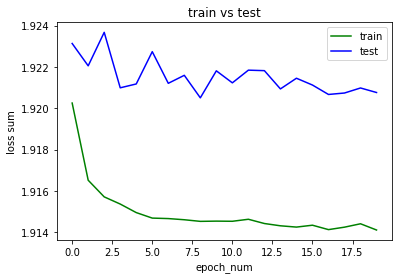

In [20]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from statistics import mean

batch_size = 8 # 250-500  # Number of samples in each batch to do(/9)
batch_size_test=60011


epoch_num = 20  # Number of epochs to train the network
lr = 0.001        # Learning rate


#140000 - train
#60011 - test

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(7, 6)
        self.fc2 = nn.Linear(6, 3)
        self.fc3 = nn.Linear(3, 1)

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        m = nn.Sigmoid()
        return m(x)


model = Model()
alpha = 0.3



#init loaders
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size_test, shuffle=True)




# define the loss (criterion) and create an optimizer
optimizer = optim.Adam(model.parameters(),lr = lr)

# sgd??   

# define lists of losses to store
all_losses  = []
test_losses = []
min_losses = []



# epochs loop
for ep in range(epoch_num):  
    model.train()
    print(".......................... epoch =",ep,"..........................")
    batch_loss = []
    # batches loop
    for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in train_loader:
       
       
        
        batch_1_feat = X_batch_1
        batch_0_feat = X_batch_0
        
        batch_label = y_batch
        batch_Z_trans = Z_batch

        optimizer.zero_grad()
        # Forward pass (predict)
        mu_1_target_class = model(batch_1_feat)
        mu_0_target_class = model(batch_0_feat)

        #convert to torch structure
        treatment_batch = treatment_batch
       

        mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
        mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
        # print("mu_0", mu_0_target_class)
        # print("mu_1", mu_1_target_class)

        ones = np.ones(shape = batch_size)
        ones = torch.from_numpy(ones).float()
        

        
      

        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

        

        
       

       
        
        
        #declare losses
        loss_cross = nn.BCELoss(reduction = 'mean')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class 
        
        
        # print("uplift_pred", uplift_pred)

        

        

        sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
        # print(loss_contrastive)
        batch_loss.append(sum_of_losses)
        # print("train AUQC:", qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))

        
        # print(batch_n, loss_contrastive)


        # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
        # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        # Backward pass and updates
        sum_of_losses.backward()                     # calculate the gradients
        optimizer.step()                    # update the weights
        # i += batch_size
        #end for !!!!!!!!!!!!!!!!!!!

    
    batch_loss  = list(batch_loss)
    all_losses.append( sum(batch_loss) / len(batch_loss) ) 

    # #work with test dataset
    print('work with test dataset')
    batch_loss = []

   
    model.eval()
    
    for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in test_loader:
        
       
        
        batch_1_feat = X_batch_1
        batch_0_feat = X_batch_0
        
        batch_label = y_batch
        batch_Z_trans = Z_batch

        # optimizer.zero_grad()
        # Forward pass (predict)
        mu_1_target_class = model(batch_1_feat)
        mu_0_target_class = model(batch_0_feat)

       
       

        mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
        mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
        # print("mu_0", mu_0_target_class)
        # print("mu_1", mu_1_target_class)

        ones = np.ones(shape = batch_size_test)
        ones = torch.from_numpy(ones).float()
        
     
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

        #declare losses
        loss_cross = nn.BCELoss(reduction = 'mean')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class   
        

        # scatter plot for mse parametres to do !!!
        sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
       
        batch_loss.append(sum_of_losses)
        

        
    batch_loss  = list(batch_loss)
    test_losses.append( sum(batch_loss) / len(batch_loss) ) 
    

    
   



plt.plot(all_losses, color='green',label='train')
plt.title('train vs test')
plt.xlabel('epoch_num')
plt.ylabel('loss sum')



plt.plot(test_losses, color='blue',label='test')
plt.legend()


plt.show()


Число замеров 100
uplift5%: mean:  0.10048244291275432 | std:  0.002587059872437374


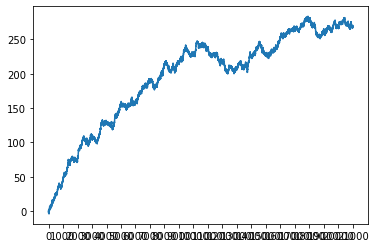

In [21]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

all_res_uplift = []

# df_train_feats = pd.read_csv("/content/drive/MyDrive/retail_hero_final_model_train_data.csv", index_col = 'client_id')
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = x_test.loc[indices_valid_new, :]
    treatment_valid = df_train_feats.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = df_train_feats.loc[indices_valid_new, 'target'].values

    X_valid_0 = X_valid.copy()
    X_valid_1 = X_valid.copy()

    X_valid_1 = X_valid_1.astype('float32')
    X_valid_1 = X_valid_1.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_valid_1 = scaler.fit_transform(X_valid_1)

    X_valid_0 = X_valid_0.astype('float32')
    X_valid_0 = X_valid_0.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_valid_0 = scaler.fit_transform(X_valid_0)

    X_valid_0 = np.c_[ X_valid_0, np.zeros(X_valid_0.shape[0]) ]
    X_valid_1 = np.c_[ X_valid_1, np.ones(X_valid_1.shape[0]) ] 

    model.eval()
    X_valid_1 = torch.FloatTensor(X_valid_1)
    X_valid_0 = torch.FloatTensor(X_valid_0)
    
    mu_1 = model(X_valid_1)
    mu_0 = model(X_valid_0)
    valid_pred = mu_1-mu_0
    
    valid_pred = valid_pred.detach().numpy()
    valid_pred = valid_pred.reshape((-1,)) 
  
    valid_pred = pd.Series(valid_pred, index = indices_valid_new)
    
  
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid, rate = 0.05)
    
    
    all_res_uplift.append(valid_scores)
   

from uplift.metrics import qini_auc_score, uplift_at_k, qini_percentile, qini_curve
from uplift.vizualization import plot_qini_curve



x1, y1 = qini_curve(target_valid, valid_pred, treatment_valid)

np.savetxt('x_siamese_nets.txt', x1)
np.savetxt('y_siamese_nets.txt', y1)

plt.plot(x1, y1)
plt.xticks(np.arange (0, x1[len(x1)-1], step=1000))
# plt.plot([ x1[0], x1[len(x1)-1] ], [ y1[0], y1[len(y1) - 1  ]] )  

print('Число замеров', j)
# print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift5%: mean: ', np.mean(all_res_uplift),"| std: ",stats.sem(all_res_uplift))



.......................... epoch = 0 ..........................
work with test dataset
.......................... epoch = 1 ..........................
work with test dataset
.......................... epoch = 2 ..........................
work with test dataset
.......................... epoch = 3 ..........................
work with test dataset
.......................... epoch = 4 ..........................
work with test dataset
.......................... epoch = 5 ..........................
work with test dataset
.......................... epoch = 6 ..........................
work with test dataset
.......................... epoch = 7 ..........................
work with test dataset
.......................... epoch = 8 ..........................
work with test dataset
.......................... epoch = 9 ..........................
work with test dataset
.......................... epoch = 10 ..........................
work with test dataset
.......................... epoch = 11 ....

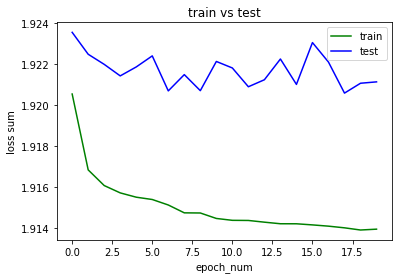

In [20]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from statistics import mean

batch_size = 8 # 250-500  # Number of samples in each batch to do(/9)
batch_size_test=60011


epoch_num = 20  # Number of epochs to train the network
lr = 0.001        # Learning rate


#140000 - train
#60011 - test

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(7, 6)
        self.fc2 = nn.Linear(6, 3)
        self.fc3 = nn.Linear(3, 1)

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        m = nn.Sigmoid()
        return m(x)


model = Model()
alpha = 0.3



#init loaders
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size_test, shuffle=True)




# define the loss (criterion) and create an optimizer
optimizer = optim.Adam(model.parameters(),lr = lr)

# sgd??   

# define lists of losses to store
all_losses  = []
test_losses = []
min_losses = []



# epochs loop
for ep in range(epoch_num):  
    model.train()
    print(".......................... epoch =",ep,"..........................")
    batch_loss = []
    # batches loop
    for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in train_loader:
       
       
        
        batch_1_feat = X_batch_1
        batch_0_feat = X_batch_0
        
        batch_label = y_batch
        batch_Z_trans = Z_batch

        optimizer.zero_grad()
        # Forward pass (predict)
        mu_1_target_class = model(batch_1_feat)
        mu_0_target_class = model(batch_0_feat)

        #convert to torch structure
        treatment_batch = treatment_batch
       

        mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
        mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
        # print("mu_0", mu_0_target_class)
        # print("mu_1", mu_1_target_class)

        ones = np.ones(shape = batch_size)
        ones = torch.from_numpy(ones).float()
        

        
      

        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

        

        
       

       
        
        
        #declare losses
        loss_cross = nn.BCELoss(reduction = 'mean')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class 
        
        
        # print("uplift_pred", uplift_pred)

        

        

        sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
        # print(loss_contrastive)
        batch_loss.append(sum_of_losses)
        # print("train AUQC:", qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))

        
        # print(batch_n, loss_contrastive)


        # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
        # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        # Backward pass and updates
        sum_of_losses.backward()                     # calculate the gradients
        optimizer.step()                    # update the weights
        # i += batch_size
        #end for !!!!!!!!!!!!!!!!!!!

    
    batch_loss  = list(batch_loss)
    all_losses.append( sum(batch_loss) / len(batch_loss) ) 

    # #work with test dataset
    print('work with test dataset')
    batch_loss = []

   
    model.eval()
    
    for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in test_loader:
        
       
        
        batch_1_feat = X_batch_1
        batch_0_feat = X_batch_0
        
        batch_label = y_batch
        batch_Z_trans = Z_batch

        # optimizer.zero_grad()
        # Forward pass (predict)
        mu_1_target_class = model(batch_1_feat)
        mu_0_target_class = model(batch_0_feat)

       
       

        mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
        mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
        # print("mu_0", mu_0_target_class)
        # print("mu_1", mu_1_target_class)

        ones = np.ones(shape = batch_size_test)
        ones = torch.from_numpy(ones).float()
        
     
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

        #declare losses
        loss_cross = nn.BCELoss(reduction = 'mean')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class   
        

        # scatter plot for mse parametres to do !!!
        sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
       
        batch_loss.append(sum_of_losses)
        

        
    batch_loss  = list(batch_loss)
    test_losses.append( sum(batch_loss) / len(batch_loss) ) 
    

    
   



plt.plot(all_losses, color='green',label='train')
plt.title('train vs test')
plt.xlabel('epoch_num')
plt.ylabel('loss sum')



plt.plot(test_losses, color='blue',label='test')
plt.legend()


plt.show()


In [21]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []
# df_train_feats = pd.read_csv("/content/drive/MyDrive/retail_hero_final_model_train_data.csv", index_col = 'client_id')
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = x_test.loc[indices_valid_new, :]
    treatment_valid = df_train_feats.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = df_train_feats.loc[indices_valid_new, 'target'].values

    X_valid_0 = X_valid.copy()
    X_valid_1 = X_valid.copy()

    X_valid_1 = X_valid_1.astype('float32')
    X_valid_1 = X_valid_1.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_valid_1 = scaler.fit_transform(X_valid_1)

    X_valid_0 = X_valid_0.astype('float32')
    X_valid_0 = X_valid_0.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_valid_0 = scaler.fit_transform(X_valid_0)

    X_valid_0 = np.c_[ X_valid_0, np.zeros(X_valid_0.shape[0]) ]
    X_valid_1 = np.c_[ X_valid_1, np.ones(X_valid_1.shape[0]) ] 

    model.eval()
    X_valid_1 = torch.FloatTensor(X_valid_1)
    X_valid_0 = torch.FloatTensor(X_valid_0)
    
    mu_1 = model(X_valid_1)
    mu_0 = model(X_valid_0)
    valid_pred = mu_1-mu_0
    
    valid_pred = valid_pred.detach().numpy()
    valid_pred = valid_pred.reshape((-1,)) 
  
    valid_pred = pd.Series(valid_pred, index = indices_valid_new)
    
    # valid_pred = clf.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))


Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation = 

Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Число замеров 100
AUQC: mean:  1135502.9357311206 | std:  342116.86548831494
uplift30%: mean:  0.055273740140212906 | std:  0.009362117741359472
Kendall_rank_correlation: mean:  0.4693333333333334 | std:  0.14636230024509056
AUUC: mean:  0.018252826730247182 | std:  0.005559177875824925


In [22]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

all_res_uplift = []

# df_train_feats = pd.read_csv("/content/drive/MyDrive/retail_hero_final_model_train_data.csv", index_col = 'client_id')
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = x_test.loc[indices_valid_new, :]
    treatment_valid = df_train_feats.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = df_train_feats.loc[indices_valid_new, 'target'].values

    X_valid_0 = X_valid.copy()
    X_valid_1 = X_valid.copy()

    X_valid_1 = X_valid_1.astype('float32')
    X_valid_1 = X_valid_1.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_valid_1 = scaler.fit_transform(X_valid_1)

    X_valid_0 = X_valid_0.astype('float32')
    X_valid_0 = X_valid_0.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_valid_0 = scaler.fit_transform(X_valid_0)

    X_valid_0 = np.c_[ X_valid_0, np.zeros(X_valid_0.shape[0]) ]
    X_valid_1 = np.c_[ X_valid_1, np.ones(X_valid_1.shape[0]) ] 

    model.eval()
    X_valid_1 = torch.FloatTensor(X_valid_1)
    X_valid_0 = torch.FloatTensor(X_valid_0)
    
    mu_1 = model(X_valid_1)
    mu_0 = model(X_valid_0)
    valid_pred = mu_1-mu_0
    
    valid_pred = valid_pred.detach().numpy()
    valid_pred = valid_pred.reshape((-1,)) 
  
    valid_pred = pd.Series(valid_pred, index = indices_valid_new)
    
  
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid, rate = 0.05)
    
    
    all_res_uplift.append(valid_scores)
   
    
print('Число замеров', j)
# print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift5%: mean: ', np.mean(all_res_uplift),"| std: ",stats.sem(all_res_uplift))



Число замеров 100
uplift5%: mean:  0.12953113751371 | std:  0.002711133914043526


Регуляризация

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from statistics import mean

batch_size = 31 # 250-500  # Number of samples in each batch to do(/9)
batch_size_test=60012


epoch_num = 20  # Number of epochs to train the network
lr = 0.001        # Learning rate


#140000 - train
#60011 - test

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(7, 6)
        
        self.fc2 = nn.Linear(6, 3)
        self.fc3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(3, 1)
        

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.fc4(x)
        m = nn.Sigmoid()
        return m(x)




model = Model()
alpha = 0.3


#init loaders
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size_test, shuffle=True)

# define the loss (criterion) and create an optimizer
optimizer = optim.Adam(model.parameters(),lr = lr)

# sgd??   

# define lists of losses to store
all_losses  = []
test_losses = []
min_losses = []



# epochs loop
for ep in range(epoch_num):  
    model.train()
    print(".......................... epoch =",ep,"..........................")
    batch_loss = []
    # batches loop
    for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in train_loader:
       
       
        
        batch_1_feat = X_batch_1
        batch_0_feat = X_batch_0
        
        batch_label = y_batch
        batch_Z_trans = Z_batch

        optimizer.zero_grad()
        # Forward pass (predict)
        mu_1_target_class = model(batch_1_feat)
        mu_0_target_class = model(batch_0_feat)

        #convert to torch structure
        treatment_batch = treatment_batch
       

        mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
        mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        

        ones = np.ones(shape = batch_size)
        ones = torch.from_numpy(ones).float()
        

        
      

        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

        
        #declare losses
        loss_cross = nn.BCELoss(reduction = 'mean')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class     

        sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
        
        batch_loss.append(sum_of_losses)
        
        # Backward pass and updates
        sum_of_losses.backward()                     # calculate the gradients
        optimizer.step()                    # update the weights
        # i += batch_size
        #end for !!!!!!!!!!!!!!!!!!!

    
    batch_loss  = list(batch_loss)
    all_losses.append( sum(batch_loss) / len(batch_loss) ) 

    # #work with test dataset
    print('work with test dataset')
    batch_loss = []

   
    model.eval()
    
    for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in test_loader:
        
       
        
        batch_1_feat = X_batch_1
        batch_0_feat = X_batch_0
        
        batch_label = y_batch
        batch_Z_trans = Z_batch

        # optimizer.zero_grad()
        # Forward pass (predict)
        mu_1_target_class = model(batch_1_feat)
        mu_0_target_class = model(batch_0_feat)

       
       

        mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
        mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
        # print("mu_0", mu_0_target_class)
        # print("mu_1", mu_1_target_class)

        ones = np.ones(shape = batch_size_test)
        ones = torch.from_numpy(ones).float()
        
     
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

        #declare losses
        loss_cross = nn.BCELoss(reduction = 'mean')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class   
        

        # scatter plot for mse parametres to do !!!
        sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
       
        batch_loss.append(sum_of_losses)
        
        
        
        
    #     #end for
    batch_loss  = list(batch_loss)
    test_losses.append( sum(batch_loss) / len(batch_loss) ) 
    

    
   

import matplotlib.pyplot as plt

plt.plot(all_losses, color='green',label='train')
plt.title('train vs test')
plt.xlabel('epoch_num')
plt.ylabel('loss sum')



plt.plot(test_losses, color='blue',label='test')
plt.legend()


plt.show()





.......................... epoch = 0 ..........................


RuntimeError: ignored

In [ ]:
from UPLIFT_modeling.uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []
df_train_feats = pd.read_csv("/content/drive/MyDrive/retail_hero_final_model_train_data.csv", index_col = 'client_id')
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = x_test.loc[indices_valid_new, :]
    treatment_valid = df_train_feats.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = df_train_feats.loc[indices_valid_new, 'target'].values

    X_valid_0 = X_valid.copy()
    X_valid_1 = X_valid.copy()

    X_valid_1 = X_valid_1.astype('float32')
    X_valid_1 = X_valid_1.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_valid_1 = scaler.fit_transform(X_valid_1)

    X_valid_0 = X_valid_0.astype('float32')
    X_valid_0 = X_valid_0.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_valid_0 = scaler.fit_transform(X_valid_0)

    X_valid_0 = np.c_[ X_valid_0, np.zeros(X_valid_0.shape[0]) ]
    X_valid_1 = np.c_[ X_valid_1, np.ones(X_valid_1.shape[0]) ] 

    model.eval()
    X_valid_1 = torch.FloatTensor(X_valid_1)
    X_valid_0 = torch.FloatTensor(X_valid_0)
    
    mu_1 = model(X_valid_1)
    mu_0 = model(X_valid_0)
    valid_pred = mu_1-mu_0
    
    valid_pred = valid_pred.detach().numpy()
    valid_pred = valid_pred.reshape((-1,)) 
  
    valid_pred = pd.Series(valid_pred, index = indices_valid_new)
    
    # valid_pred = clf.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.511111111111

alpha = 0.3 число эпох = 20

.......................... epoch = 0 ..........................
work with test dataset
.......................... epoch = 1 ..........................
work with test dataset
.......................... epoch = 2 ..........................
work with test dataset
.......................... epoch = 3 ..........................
work with test dataset
.......................... epoch = 4 ..........................
work with test dataset
.......................... epoch = 5 ..........................
work with test dataset
.......................... epoch = 6 ..........................
work with test dataset
.......................... epoch = 7 ..........................
work with test dataset
.......................... epoch = 8 ..........................
work with test dataset
.......................... epoch = 9 ..........................
work with test dataset
.......................... epoch = 10 ..........................
work with test dataset
.......................... epoch = 11 ....

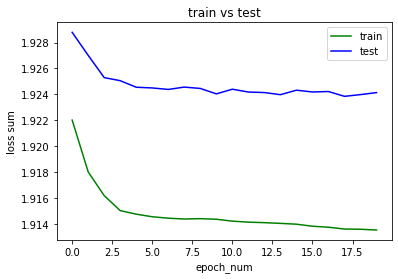

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from statistics import mean

batch_size = 31 # 250-500  # Number of samples in each batch to do(/9)
batch_size_test=60012


epoch_num = 20  # Number of epochs to train the network
lr = 0.001        # Learning rate


#140000 - train
#60011 - test

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(7, 6)
        self.fc2 = nn.Linear(6, 3)
        self.fc3 = nn.Linear(3, 1)

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        m = nn.Sigmoid()
        return m(x)

# class Model(nn.Module):
#     def __init__(self):
#         super(Model, self).__init__()
        
#         self.fc1 = nn.Linear(334, 290)
#         self.fc2 = nn.Linear(290, 210)
#         self.fc3 = nn.Linear(210, 170)
#         self.fc4 = nn.Linear(170, 130)
#         self.fc5 = nn.Linear(130, 90)
#         self.fc6 = nn.Linear(90, 10)
#         self.fc7 = nn.Linear(10, 1)


#         # # ...
#         # self.fc2 = nn.Linear(200, 100)


#         # self.fc3 = nn.Linear(100, 1) # conv1d??

#     def forward(self, x):
        
#         x = F.relu(self.fc1(x))  #leaky_relu ???
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))  #leaky_relu ???
#         x = F.relu(self.fc4(x))
#         x = F.relu(self.fc5(x))  #leaky_relu ???
#         x = F.relu(self.fc6(x))
#         x = self.fc7(x)
#         m = nn.Sigmoid()
#         return m(x)
        

# class Model(nn.Module):
#     def __init__(self): 
#         super(Model, self).__init__()
#         self.classifier = nn.Sequential(
#             nn.Linear(334, 200),
#             nn.BatchNorm1d(200), #applying batch norm
#             nn.ReLU(),
#             nn.Linear(200, 100),
#             nn.BatchNorm1d(100),
#             nn.ReLU(),
#             nn.Linear(100, 1)
#         )
             
#     def forward(self, x):
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)
#         m = nn.Sigmoid()
#         return m(x)
#         # return x

model = Model()
alpha = 0.3

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
# model.to(device)
# print(model)


# #convert to torch structure
# X_test_1_tensor = torch.FloatTensor(X_test_1) 
# X_test_0_tensor = torch.FloatTensor(X_test_0)


# #convert to torch structure
# treatment_test = treatment_test.to_numpy()
# treatment_test = torch.from_numpy(treatment_test).int()
# treatment_test = Variable(treatment_test)


# #convert to torch structure
# y_test = y_test.to_numpy()
# y_test = torch.from_numpy(y_test).float()
# y_test  = Variable(y_test)


# #convert to torch structure
# Z_trans_test = Z_trans_test.to_numpy()
# Z_trans_test = torch.from_numpy(Z_trans_test).float()
# Z_trans_test = Variable(Z_trans_test)


#init loaders
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size_test, shuffle=True)




# define the loss (criterion) and create an optimizer
optimizer = optim.Adam(model.parameters(),lr = lr)

# sgd??   

# define lists of losses to store
all_losses  = []
test_losses = []
min_losses = []



# epochs loop
for ep in range(epoch_num):  
    model.train()
    print(".......................... epoch =",ep,"..........................")
    batch_loss = []
    # batches loop
    for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in train_loader:
       
       
        
        batch_1_feat = X_batch_1
        batch_0_feat = X_batch_0
        
        batch_label = y_batch
        batch_Z_trans = Z_batch

        optimizer.zero_grad()
        # Forward pass (predict)
        mu_1_target_class = model(batch_1_feat)
        mu_0_target_class = model(batch_0_feat)

        #convert to torch structure
        treatment_batch = treatment_batch
       

        mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
        mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
        # print("mu_0", mu_0_target_class)
        # print("mu_1", mu_1_target_class)

        ones = np.ones(shape = batch_size)
        ones = torch.from_numpy(ones).float()
        

        
      

        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

        

        
       

       
        
        
        #declare losses
        loss_cross = nn.BCELoss(reduction = 'mean')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class 
        
        
        # print("uplift_pred", uplift_pred)

        

        

        sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
        # print(loss_contrastive)
        batch_loss.append(sum_of_losses)
        # print("train AUQC:", qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))

        
        # print(batch_n, loss_contrastive)


        # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
        # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        # Backward pass and updates
        sum_of_losses.backward()                     # calculate the gradients
        optimizer.step()                    # update the weights
        # i += batch_size
        #end for !!!!!!!!!!!!!!!!!!!

    # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
    # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
    batch_loss  = list(batch_loss)
    all_losses.append( sum(batch_loss) / len(batch_loss) ) 

    # #work with test dataset
    print('work with test dataset')
    batch_loss = []

   
    model.eval()
    
    for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in test_loader:
        
       
        
        batch_1_feat = X_batch_1
        batch_0_feat = X_batch_0
        
        batch_label = y_batch
        batch_Z_trans = Z_batch

        # optimizer.zero_grad()
        # Forward pass (predict)
        mu_1_target_class = model(batch_1_feat)
        mu_0_target_class = model(batch_0_feat)

       
       

        mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
        mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
        # print("mu_0", mu_0_target_class)
        # print("mu_1", mu_1_target_class)

        ones = np.ones(shape = batch_size_test)
        ones = torch.from_numpy(ones).float()
        
     
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

        #declare losses
        loss_cross = nn.BCELoss(reduction = 'mean')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class   
        

        # scatter plot for mse parametres to do !!!
        sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
       
        batch_loss.append(sum_of_losses)
        

        
        # print(batch_n, loss_contrastive)


        # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
        # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        
        
    #     #end for
    batch_loss  = list(batch_loss)
    test_losses.append( sum(batch_loss) / len(batch_loss) ) 
    

    
   

import matplotlib.pyplot as plt

plt.plot(all_losses, color='green',label='train')
plt.title('train vs test')
plt.xlabel('epoch_num')
plt.ylabel('loss sum')



plt.plot(test_losses, color='blue',label='test')
plt.legend()


plt.show()





alpha = 0.0 число эпох = 19

.......................... epoch = 0 ..........................
work with test dataset
.......................... epoch = 1 ..........................
work with test dataset
.......................... epoch = 2 ..........................
work with test dataset
.......................... epoch = 3 ..........................
work with test dataset
.......................... epoch = 4 ..........................
work with test dataset
.......................... epoch = 5 ..........................
work with test dataset
.......................... epoch = 6 ..........................
work with test dataset
.......................... epoch = 7 ..........................
work with test dataset
.......................... epoch = 8 ..........................
work with test dataset
.......................... epoch = 9 ..........................
work with test dataset
.......................... epoch = 10 ..........................
work with test dataset
.......................... epoch = 11 ....

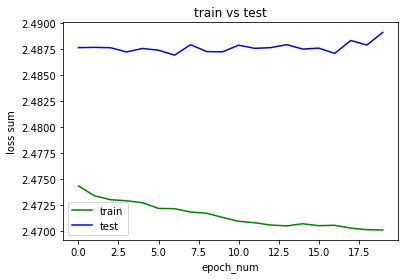

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from statistics import mean

batch_size = 31 # 250-500  # Number of samples in each batch to do(/9)
batch_size_test=60012 


epoch_num = 20  # Number of epochs to train the network
lr = 0.001        # Learning rate


#140000 - train
#60011 - test

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(7, 6)
        self.fc2 = nn.Linear(6, 3)
        self.fc3 = nn.Linear(3, 1)

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        m = nn.Sigmoid()
        return m(x)

# class Model(nn.Module):
#     def __init__(self):
#         super(Model, self).__init__()
        
#         self.fc1 = nn.Linear(334, 290)
#         self.fc2 = nn.Linear(290, 210)
#         self.fc3 = nn.Linear(210, 170)
#         self.fc4 = nn.Linear(170, 130)
#         self.fc5 = nn.Linear(130, 90)
#         self.fc6 = nn.Linear(90, 10)
#         self.fc7 = nn.Linear(10, 1)


#         # # ...
#         # self.fc2 = nn.Linear(200, 100)


#         # self.fc3 = nn.Linear(100, 1) # conv1d??

#     def forward(self, x):
        
#         x = F.relu(self.fc1(x))  #leaky_relu ???
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))  #leaky_relu ???
#         x = F.relu(self.fc4(x))
#         x = F.relu(self.fc5(x))  #leaky_relu ???
#         x = F.relu(self.fc6(x))
#         x = self.fc7(x)
#         m = nn.Sigmoid()
#         return m(x)
        

# class Model(nn.Module):
#     def __init__(self): 
#         super(Model, self).__init__()
#         self.classifier = nn.Sequential(
#             nn.Linear(334, 200),
#             nn.BatchNorm1d(200), #applying batch norm
#             nn.ReLU(),
#             nn.Linear(200, 100),
#             nn.BatchNorm1d(100),
#             nn.ReLU(),
#             nn.Linear(100, 1)
#         )
             
#     def forward(self, x):
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)
#         m = nn.Sigmoid()
#         return m(x)
#         # return x

model = Model()
alpha = 0.0

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
# model.to(device)
# print(model)


# #convert to torch structure
# X_test_1_tensor = torch.FloatTensor(X_test_1) 
# X_test_0_tensor = torch.FloatTensor(X_test_0)


# #convert to torch structure
# treatment_test = treatment_test.to_numpy()
# treatment_test = torch.from_numpy(treatment_test).int()
# treatment_test = Variable(treatment_test)


# #convert to torch structure
# y_test = y_test.to_numpy()
# y_test = torch.from_numpy(y_test).float()
# y_test  = Variable(y_test)


# #convert to torch structure
# Z_trans_test = Z_trans_test.to_numpy()
# Z_trans_test = torch.from_numpy(Z_trans_test).float()
# Z_trans_test = Variable(Z_trans_test)


#init loaders
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size_test, shuffle=True)




# define the loss (criterion) and create an optimizer
optimizer = optim.Adam(model.parameters(),lr = lr)

# sgd??   

# define lists of losses to store
all_losses  = []
test_losses = []
min_losses = []



# epochs loop
for ep in range(epoch_num):  
    model.train()
    print(".......................... epoch =",ep,"..........................")
    batch_loss = []
    # batches loop
    for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in train_loader:
       
       
        
        batch_1_feat = X_batch_1
        batch_0_feat = X_batch_0
        
        batch_label = y_batch
        batch_Z_trans = Z_batch

        optimizer.zero_grad()
        # Forward pass (predict)
        mu_1_target_class = model(batch_1_feat)
        mu_0_target_class = model(batch_0_feat)

        #convert to torch structure
        treatment_batch = treatment_batch
       

        mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
        mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
        # print("mu_0", mu_0_target_class)
        # print("mu_1", mu_1_target_class)

        ones = np.ones(shape = batch_size)
        ones = torch.from_numpy(ones).float()
        

        
      

        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

        

        
       

       
        
        
        #declare losses
        loss_cross = nn.BCELoss(reduction = 'mean')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class 
        
        
        # print("uplift_pred", uplift_pred)

        

        

        sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
        # print(loss_contrastive)
        batch_loss.append(sum_of_losses)
        # print("train AUQC:", qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))

        
        # print(batch_n, loss_contrastive)


        # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
        # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        # Backward pass and updates
        sum_of_losses.backward()                     # calculate the gradients
        optimizer.step()                    # update the weights
        # i += batch_size
        #end for !!!!!!!!!!!!!!!!!!!

    # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
    # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
    batch_loss  = list(batch_loss)
    all_losses.append( sum(batch_loss) / len(batch_loss) ) 

    # #work with test dataset
    print('work with test dataset')
    batch_loss = []

   
    model.eval()
    
    for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in test_loader:
        
       
        
        batch_1_feat = X_batch_1
        batch_0_feat = X_batch_0
        
        batch_label = y_batch
        batch_Z_trans = Z_batch

        # optimizer.zero_grad()
        # Forward pass (predict)
        mu_1_target_class = model(batch_1_feat)
        mu_0_target_class = model(batch_0_feat)

       
       

        mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
        mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
        # print("mu_0", mu_0_target_class)
        # print("mu_1", mu_1_target_class)

        ones = np.ones(shape = batch_size_test)
        ones = torch.from_numpy(ones).float()
        
     
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

        #declare losses
        loss_cross = nn.BCELoss(reduction = 'mean')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class   
        

        # scatter plot for mse parametres to do !!!
        sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
       
        batch_loss.append(sum_of_losses)
        

        
        # print(batch_n, loss_contrastive)


        # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
        # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        
        
    #     #end for
    batch_loss  = list(batch_loss)
    test_losses.append( sum(batch_loss) / len(batch_loss) ) 
    

    
   

import matplotlib.pyplot as plt

plt.plot(all_losses, color='green',label='train')
plt.title('train vs test')
plt.xlabel('epoch_num')
plt.ylabel('loss sum')



plt.plot(test_losses, color='blue',label='test')
plt.legend()


plt.show()





In [ ]:
from UPLIFT_modeling.uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []
df_train_feats = pd.read_csv("/content/drive/MyDrive/retail_hero_final_model_train_data.csv", index_col = 'client_id')
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = x_test.loc[indices_valid_new, :]
    treatment_valid = df_train_feats.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = df_train_feats.loc[indices_valid_new, 'target'].values

    X_valid_0 = X_valid.copy()
    X_valid_1 = X_valid.copy()

    X_valid_1 = X_valid_1.astype('float32')
    X_valid_1 = X_valid_1.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_valid_1 = scaler.fit_transform(X_valid_1)

    X_valid_0 = X_valid_0.astype('float32')
    X_valid_0 = X_valid_0.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_valid_0 = scaler.fit_transform(X_valid_0)

    X_valid_0 = np.c_[ X_valid_0, np.zeros(X_valid_0.shape[0]) ]
    X_valid_1 = np.c_[ X_valid_1, np.ones(X_valid_1.shape[0]) ] 

    model.eval()
    X_valid_1 = torch.FloatTensor(X_valid_1)
    X_valid_0 = torch.FloatTensor(X_valid_0)
    
    mu_1 = model(X_valid_1)
    mu_0 = model(X_valid_0)
    valid_pred = mu_1-mu_0
    
    valid_pred = valid_pred.detach().numpy()
    valid_pred = valid_pred.reshape((-1,)) 
  
    valid_pred = pd.Series(valid_pred, index = indices_valid_new)
    
    # valid_pred = clf.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.7333333333333333 with p_

In [ ]:
from UPLIFT_modeling.uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

In [ ]:
from UPLIFT_modeling.uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []
df_train_feats = pd.read_csv("/content/drive/MyDrive/retail_hero_final_model_train_data.csv", index_col = 'client_id')
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = x_test.loc[indices_valid_new, :]
    treatment_valid = df_train_feats.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = df_train_feats.loc[indices_valid_new, 'target'].values

    X_valid_0 = X_valid.copy()
    X_valid_1 = X_valid.copy()

    X_valid_1 = X_valid_1.astype('float32')
    X_valid_1 = X_valid_1.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_valid_1 = scaler.fit_transform(X_valid_1)

    X_valid_0 = X_valid_0.astype('float32')
    X_valid_0 = X_valid_0.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_valid_0 = scaler.fit_transform(X_valid_0)

    X_valid_0 = np.c_[ X_valid_0, np.zeros(X_valid_0.shape[0]) ]
    X_valid_1 = np.c_[ X_valid_1, np.ones(X_valid_1.shape[0]) ] 

    model.eval()
    X_valid_1 = torch.FloatTensor(X_valid_1)
    X_valid_0 = torch.FloatTensor(X_valid_0)
    
    mu_1 = model(X_valid_1)
    mu_0 = model(X_valid_0)
    valid_pred = mu_1-mu_0
    
    valid_pred = valid_pred.detach().numpy()
    valid_pred = valid_pred.reshape((-1,)) 
  
    valid_pred = pd.Series(valid_pred, index = indices_valid_new)
    
    # valid_pred = clf.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank

# Раскачка сиамских сетей

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from statistics import mean

batch_size = 8 # 250-500  # Number of samples in each batch to do(/9)
batch_size_test=60011


epoch_num = 10  # Number of epochs to train the network
lr = 0.0001        # Learning rate


#140000 - train
#60011 - test

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(7, 6)
        self.fc2 = nn.Linear(6, 3)
        self.fc3 = nn.Linear(3, 1)

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        m = nn.Sigmoid()
        return m(x)

# class Model(nn.Module):
#     def __init__(self):
#         super(Model, self).__init__()
        
#         self.fc1 = nn.Linear(334, 290)
#         self.fc2 = nn.Linear(290, 210)
#         self.fc3 = nn.Linear(210, 170)
#         self.fc4 = nn.Linear(170, 130)
#         self.fc5 = nn.Linear(130, 90)
#         self.fc6 = nn.Linear(90, 10)
#         self.fc7 = nn.Linear(10, 1)


#         # # ...
#         # self.fc2 = nn.Linear(200, 100)


#         # self.fc3 = nn.Linear(100, 1) # conv1d??

#     def forward(self, x):
        
#         x = F.relu(self.fc1(x))  #leaky_relu ???
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))  #leaky_relu ???
#         x = F.relu(self.fc4(x))
#         x = F.relu(self.fc5(x))  #leaky_relu ???
#         x = F.relu(self.fc6(x))
#         x = self.fc7(x)
#         m = nn.Sigmoid()
#         return m(x)
        

# class Model(nn.Module):
#     def __init__(self): 
#         super(Model, self).__init__()
#         self.classifier = nn.Sequential(
#             nn.Linear(334, 200),
#             nn.BatchNorm1d(200), #applying batch norm
#             nn.ReLU(),
#             nn.Linear(200, 100),
#             nn.BatchNorm1d(100),
#             nn.ReLU(),
#             nn.Linear(100, 1)
#         )
             
#     def forward(self, x):
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)
#         m = nn.Sigmoid()
#         return m(x)
#         # return x

model = Model()
alpha = 0.3

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
# model.to(device)
# print(model)


# #convert to torch structure
# X_test_1_tensor = torch.FloatTensor(X_test_1) 
# X_test_0_tensor = torch.FloatTensor(X_test_0)


# #convert to torch structure
# treatment_test = treatment_test.to_numpy()
# treatment_test = torch.from_numpy(treatment_test).int()
# treatment_test = Variable(treatment_test)


# #convert to torch structure
# y_test = y_test.to_numpy()
# y_test = torch.from_numpy(y_test).float()
# y_test  = Variable(y_test)


# #convert to torch structure
# Z_trans_test = Z_trans_test.to_numpy()
# Z_trans_test = torch.from_numpy(Z_trans_test).float()
# Z_trans_test = Variable(Z_trans_test)


#init loaders
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size_test, shuffle=True)




# define the loss (criterion) and create an optimizer
optimizer = optim.Adam(model.parameters(),lr = lr)

# sgd??   

# define lists of losses to store
all_losses  = []
test_losses = []
min_losses = []



# epochs loop
for ep in range(epoch_num):  
    model.train()
    print(".......................... epoch =",ep,"..........................")
    batch_loss = []
    # batches loop
    for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in train_loader:
       
       
        
        batch_1_feat = X_batch_1
        batch_0_feat = X_batch_0
        
        batch_label = y_batch
        batch_Z_trans = Z_batch

        optimizer.zero_grad()
        # Forward pass (predict)
        mu_1_target_class = model(batch_1_feat)
        mu_0_target_class = model(batch_0_feat)

        #convert to torch structure
        treatment_batch = treatment_batch
       

        mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
        mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
        # print("mu_0", mu_0_target_class)
        # print("mu_1", mu_1_target_class)

        ones = np.ones(shape = batch_size)
        ones = torch.from_numpy(ones).float()
        

        
      

        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

        

        
       

       
        
        
        #declare losses
        loss_cross = nn.BCELoss(reduction = 'mean')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class 
        
        
        # print("uplift_pred", uplift_pred)

        

        

        sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
        # print(loss_contrastive)
        batch_loss.append(sum_of_losses)
        # print("train AUQC:", qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))

        
        # print(batch_n, loss_contrastive)


        # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
        # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        # Backward pass and updates
        sum_of_losses.backward()                     # calculate the gradients
        optimizer.step()                    # update the weights
        # i += batch_size
        #end for !!!!!!!!!!!!!!!!!!!

    # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
    # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
    batch_loss  = list(batch_loss)
    all_losses.append( sum(batch_loss) / len(batch_loss) ) 

    # #work with test dataset
    print('work with test dataset')
    batch_loss = []

   
    model.eval()
    
    for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in test_loader:
        
       
        
        batch_1_feat = X_batch_1
        batch_0_feat = X_batch_0
        
        batch_label = y_batch
        batch_Z_trans = Z_batch

        # optimizer.zero_grad()
        # Forward pass (predict)
        mu_1_target_class = model(batch_1_feat)
        mu_0_target_class = model(batch_0_feat)

       
       

        mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
        mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
        # print("mu_0", mu_0_target_class)
        # print("mu_1", mu_1_target_class)

        ones = np.ones(shape = batch_size_test)
        ones = torch.from_numpy(ones).float()
        
     
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

        #declare losses
        loss_cross = nn.BCELoss(reduction = 'mean')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class   
        

        # scatter plot for mse parametres to do !!!
        sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
       
        batch_loss.append(sum_of_losses)
        

        
        # print(batch_n, loss_contrastive)


        # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
        # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        
        
    #     #end for
    batch_loss  = list(batch_loss)
    test_losses.append( sum(batch_loss) / len(batch_loss) ) 
    

    
   

import matplotlib.pyplot as plt

plt.plot(all_losses, color='green',label='train')
plt.title('train vs test')
plt.xlabel('epoch_num')
plt.ylabel('loss sum')



plt.plot(test_losses, color='blue',label='test')
plt.legend()


plt.show()





.......................... epoch = 0 ..........................
work with test dataset
.......................... epoch = 1 ..........................
work with test dataset
.......................... epoch = 2 ..........................
work with test dataset
.......................... epoch = 3 ..........................
work with test dataset
.......................... epoch = 4 ..........................
work with test dataset
.......................... epoch = 5 ..........................
work with test dataset
.......................... epoch = 6 ..........................


KeyboardInterrupt: ignored

In [ ]:
from sklearn.preprocessing import StandardScaler 
import numpy as np


scaler = StandardScaler(with_std = True, with_mean = True)

# x_train = x_train.copy()


# x_train_1 = x_train.copy()


# x_train = x_train.astype('float32')
# x_train = x_train.replace([np.inf, -np.inf], np.nan).fillna(0)
x_train = scaler.fit_transform(x_train)

class trainData(Dataset):
    
    def __init__(self, X_data_0,X_data_1,Z_trans,treatment, y_data):
        self.X_data_0 = X_data_0
        self.X_data_1 = X_data_1
        self.Z_trans = Z_trans
        self.treatment = treatment
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data_0[index], self.X_data_1[index],self.Z_trans[index], self.treatment[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data_0)


train_data = trainData(torch.FloatTensor(x_train),torch.FloatTensor(x_train),torch.FloatTensor(Z_trans_train.values),torch.FloatTensor(treatment_train.values), 
                       torch.FloatTensor(y_train.values))
## test data    

class testData(Dataset):
    
    def __init__(self, X_data_0,X_data_1,Z_trans,treatment,y_data):
        self.X_data_0 = X_data_0
        self.X_data_1 = X_data_1
        self.Z_trans = Z_trans
        self.treatment = treatment
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data_0[index], self.X_data_1[index],self.Z_trans[index], self.treatment[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data_0)
    

test_data = testData(torch.FloatTensor(X_test_0),torch.FloatTensor(X_test_1), torch.FloatTensor(Z_trans_test),torch.FloatTensor(treatment_test), 
                       torch.FloatTensor(y_test))

.......................... epoch = 0 ..........................
work with test dataset
.......................... epoch = 1 ..........................
work with test dataset
.......................... epoch = 2 ..........................
work with test dataset
.......................... epoch = 3 ..........................
work with test dataset
.......................... epoch = 4 ..........................
work with test dataset
.......................... epoch = 5 ..........................
work with test dataset
.......................... epoch = 6 ..........................
work with test dataset
.......................... epoch = 7 ..........................
work with test dataset
.......................... epoch = 8 ..........................
work with test dataset
.......................... epoch = 9 ..........................
work with test dataset


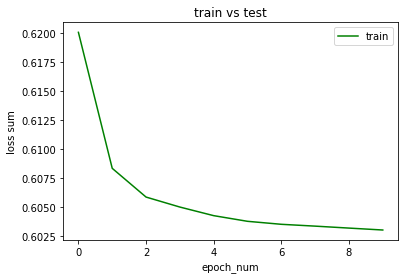

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from statistics import mean

batch_size = 8 # 250-500  # Number of samples in each batch to do(/9)
batch_size_test=60011


epoch_num = 10  # Number of epochs to train the network
lr = 0.001        # Learning rate


#140000 - train
#60011 - test

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(7, 6)
        self.fc2 = nn.Linear(6, 3)
        self.fc3 = nn.Linear(3, 1)

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        m = nn.Sigmoid()
        return m(x)

# class Model(nn.Module):
#     def __init__(self):
#         super(Model, self).__init__()
        
#         self.fc1 = nn.Linear(334, 290)
#         self.fc2 = nn.Linear(290, 210)
#         self.fc3 = nn.Linear(210, 170)
#         self.fc4 = nn.Linear(170, 130)
#         self.fc5 = nn.Linear(130, 90)
#         self.fc6 = nn.Linear(90, 10)
#         self.fc7 = nn.Linear(10, 1)


#         # # ...
#         # self.fc2 = nn.Linear(200, 100)


#         # self.fc3 = nn.Linear(100, 1) # conv1d??

#     def forward(self, x):
        
#         x = F.relu(self.fc1(x))  #leaky_relu ???
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))  #leaky_relu ???
#         x = F.relu(self.fc4(x))
#         x = F.relu(self.fc5(x))  #leaky_relu ???
#         x = F.relu(self.fc6(x))
#         x = self.fc7(x)
#         m = nn.Sigmoid()
#         return m(x)
        

# class Model(nn.Module):
#     def __init__(self): 
#         super(Model, self).__init__()
#         self.classifier = nn.Sequential(
#             nn.Linear(334, 200),
#             nn.BatchNorm1d(200), #applying batch norm
#             nn.ReLU(),
#             nn.Linear(200, 100),
#             nn.BatchNorm1d(100),
#             nn.ReLU(),
#             nn.Linear(100, 1)
#         )
             
#     def forward(self, x):
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)
#         m = nn.Sigmoid()
#         return m(x)
#         # return x

model = Model()
alpha = 0.3

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
# model.to(device)
# print(model)


# #convert to torch structure
# X_test_1_tensor = torch.FloatTensor(X_test_1) 
# X_test_0_tensor = torch.FloatTensor(X_test_0)


# #convert to torch structure
# treatment_test = treatment_test.to_numpy()
# treatment_test = torch.from_numpy(treatment_test).int()
# treatment_test = Variable(treatment_test)


# #convert to torch structure
# y_test = y_test.to_numpy()
# y_test = torch.from_numpy(y_test).float()
# y_test  = Variable(y_test)


# #convert to torch structure
# Z_trans_test = Z_trans_test.to_numpy()
# Z_trans_test = torch.from_numpy(Z_trans_test).float()
# Z_trans_test = Variable(Z_trans_test)


#init loaders
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size_test, shuffle=True)




# define the loss (criterion) and create an optimizer
optimizer = optim.Adam(model.parameters(),lr = lr)

# sgd??   

# define lists of losses to store
all_losses  = []
test_losses = []
min_losses = []



# epochs loop
for ep in range(epoch_num):  
    model.train()
    print(".......................... epoch =",ep,"..........................")
    batch_loss = []
    # batches loop
    for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in train_loader:
       
       
        
        batch_1_feat = X_batch_1
        batch_0_feat = X_batch_0
        
        batch_label = y_batch
        batch_Z_trans = Z_batch

        optimizer.zero_grad()
        # Forward pass (predict)
        treatment_batch = torch.unsqueeze(treatment_batch, 1)
        X = torch.cat((X_batch_0, treatment_batch), dim = 1)
        pred = model(X)
        

        #convert to torch structure
        treatment_batch = treatment_batch
       

        

        
        
        #declare losses
        loss_cross = nn.BCELoss(reduction = 'mean')
        loss_MSE = nn.MSELoss()

        pred = torch.reshape(pred, shape = (-1,))
        sum_of_losses = torch.mean( loss_cross( pred, batch_label))
        # print(loss_contrastive)
        batch_loss.append(sum_of_losses)
        # print("train AUQC:", qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))

        
        # print(batch_n, loss_contrastive)


        # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
        # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        # Backward pass and updates
        sum_of_losses.backward()                     # calculate the gradients
        optimizer.step()                    # update the weights
        # i += batch_size
        #end for !!!!!!!!!!!!!!!!!!!

    # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
    # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
    batch_loss  = list(batch_loss)
    all_losses.append( sum(batch_loss) / len(batch_loss) ) 

    # #work with test dataset
    print('work with test dataset')
    batch_loss = []

   
    # model.eval()
    
    # for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in test_loader:
        
       
        
    #     batch_1_feat = X_batch_1
    #     batch_0_feat = X_batch_0
        
    #     batch_label = y_batch
    #     batch_Z_trans = Z_batch

    #     # optimizer.zero_grad()
    #     # Forward pass (predict)
    #     mu_1_target_class = model(batch_1_feat)
    #     mu_0_target_class = model(batch_0_feat)

       
       

    #     mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
    #     mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
    #     # print("mu_0", mu_0_target_class)
    #     # print("mu_1", mu_1_target_class)

    #     ones = np.ones(shape = batch_size_test)
    #     ones = torch.from_numpy(ones).float()
        
     
    #     #implements mu = T * mu_1 + (1-T) * mu_0
    #     uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

    #     #declare losses
    #     loss_cross = nn.BCELoss(reduction = 'mean')
    #     loss_MSE = nn.MSELoss()

    #     #implements uplift_predicted = mu_1 - mu_0
    #     uplift_pred = mu_1_target_class - mu_0_target_class   
        

    #     # scatter plot for mse parametres to do !!!
    #     sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
       
    #     batch_loss.append(sum_of_losses)
        

        
    #     # print(batch_n, loss_contrastive)


    #     # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
    #     # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        
        
    # #     #end for
    # batch_loss  = list(batch_loss)
    # test_losses.append( sum(batch_loss) / len(batch_loss) ) 
    

    
   

import matplotlib.pyplot as plt

plt.plot(all_losses, color='green',label='train')
plt.title('train vs test')
plt.xlabel('epoch_num')
plt.ylabel('loss sum')



# plt.plot(test_losses, color='blue',label='test')
plt.legend()


plt.show()





In [ ]:
from UPLIFT_modeling.uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []
df_train_feats = pd.read_csv("/content/drive/MyDrive/retail_hero_final_model_train_data.csv", index_col = 'client_id')
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = x_test.loc[indices_valid_new, :]
    treatment_valid = df_train_feats.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = df_train_feats.loc[indices_valid_new, 'target'].values

    X_valid_0 = X_valid.copy()
    X_valid_1 = X_valid.copy()

    # X_valid_1 = X_valid_1.astype('float32')
    # X_valid_1 = X_valid_1.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_valid_1 = scaler.fit_transform(X_valid_1)

    # X_valid_0 = X_valid_0.astype('float32')
    # X_valid_0 = X_valid_0.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_valid_0 = scaler.fit_transform(X_valid_0)

    X_valid_0 = np.c_[ X_valid_0, np.zeros(X_valid_0.shape[0]) ]
    X_valid_1 = np.c_[ X_valid_1, np.ones(X_valid_1.shape[0]) ] 

    model.eval()
    X_valid_1 = torch.FloatTensor(X_valid_1)
    X_valid_0 = torch.FloatTensor(X_valid_0)
    
    mu_1 = model(X_valid_1)
    mu_0 = model(X_valid_0)
    valid_pred = mu_1-mu_0
    
    valid_pred = valid_pred.detach().numpy()
    valid_pred = valid_pred.reshape((-1,)) 
  
    valid_pred = pd.Series(valid_pred, index = indices_valid_new)
    
    # valid_pred = clf.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  -0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.11111111